In [1]:
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import os
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib
import math
import hdbscan
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid

In [2]:
output_path = './Multi_F_Results'

In [3]:
state_lookup = pd.read_csv('./census_geometry/state_lookup.csv')

# mi = gpd.read_file(os.path.join(output_path, 'MH_F_mi_all.geojson'))

mi = gpd.GeoDataFrame()
for i in range(0, 15):
    temp_path = os.path.join(output_path, f'N_{i}', f'Multi_F_mi.geojson')
    if os.path.exists(temp_path):
        temp_ = gpd.read_file(temp_path)
        temp_['iter'] = i
        mi = pd.concat([mi, temp_], ignore_index=True)

mi = mi.fillna(0)
mi['STATE'] = mi.apply(lambda x:x['ID'][0:2], axis=1)
mi = mi.merge(state_lookup, left_on='STATE', right_on='Abbr', how='left')

mi

ID        LAT         LON                    NAME  LIBRARY_ID  \
0    CA10114  36.416309 -119.003224            TERMINUS DAM         199   
1    CA10113  36.060671 -118.919340  Richard L. Schafer Dam          98   
2    NY00468  42.733294  -77.907232        MOUNT MORRIS DAM         316   
3    CA10109  38.151041 -120.813699           NEW HOGAN DAM         297   
4    CA10104  37.906801 -120.934059          FARMINGTON DAM         260   
..       ...        ...         ...                     ...         ...   
340  MN00574  46.217141  -96.179236              ORWELL DAM        6188   
341  IL00117  38.037328  -88.961679                REND DAM        6106   
342  OK10318  36.549055  -99.560571         FORT SUPPLY DAM        4203   
343  MS01494  33.821629  -89.772394             GRENADA DAM        5646   
344  CA10244  37.110662 -119.884580              HIDDEN DAM        5887   

    LIBRARY_TYPE  MH_F   IH_F  TAS_F  SS_F  ...   pval_GROUPQ  dist_GROUPQ  \
0      dam_study  True  False   True  True  ...  1.477466e-01        25000   
1      dam_study  True  False   True  True  ...  6.966340e-07        25000   
2      dam_study  True  False   True  True  ...  0.000000e+00         2500   
3      dam_study  True  False   True  True  ...  1.231008e-03        25000   
4      dam_study  True  False   True  True  ...  0.000000e+00         2500   
..           ...   ...    ...    ...   ...  ...           ...          ...   
340    dam_study  True   True   True  True  ...  1.479929e-07         1000   
341    dam_study  True   True   True  True  ...  1.204141e-04         1000   
342    dam_study  True  False   True  True  ...  8.662373e-34         1000   
343    dam_study  True   True   True  True  ...  4.505838e-01        50000   
344    dam_study  True   True   True  True  ...  7.388435e-04         1000   

                        geometry  iter  STATE         Name  Abbr  FIPS  \
0    POINT (-119.00322 36.41631)     0     CA   California    CA     6   
1    POINT (-118.91934 36.06067)     0     CA   California    CA     6   
2     POINT (-77.90723 42.73329)     0     NY     New York    NY    36   
3    POINT (-120.81370 38.15104)     0     CA   California    CA     6   
4    POINT (-120.93406 37.90680)     0     CA   California    CA     6   
..                           ...   ...    ...          ...   ...   ...   
340   POINT (-96.17924 46.21714)    14     MN    Minnesota    MN    27   
341   POINT (-88.96168 38.03733)    14     IL     Illinois    IL    17   
342   POINT (-99.56057 36.54905)    14     OK     Oklahoma    OK    40   
343   POINT (-89.77239 33.82163)    14     MS  Mississippi    MS    28   
344  POINT (-119.88458 37.11066)    14     CA   California    CA     6   

     ContiguousUS            Region  
0               1           Pacific  
1               1           Pacific  
2               1    MiddleAtlantic  
3               1           Pacific  
4               1           Pacific  
..            ...               ...  
340             1  WestNorthCentral  
341             1  EastNorthCentral  
342             1  WestSouthCentral  
343             1  EastSouthCentral  
344             1           Pacific  

[345 rows x 69 columns]

In [4]:
# str: single variable
# list: [[To be summed and set as numerator], demonimator]  
census_info = {
                "EP_POV150" : [['S1701_C01_040E'], 'S1701_C01_001E'],
                "EP_UNEMP"  : 'DP03_0009PE',
                "EP_HBURD"  : [['S2503_C01_028E', 'S2503_C01_032E', 'S2503_C01_036E', 'S2503_C01_040E'], 
                            'S2503_C01_001E'],
                "EP_NOHSDP" : 'S0601_C01_033E',
                "EP_UNINSUR" : 'S2701_C05_001E',
                "EP_AGE65" : 'S0101_C02_030E',
                "EP_AGE17" : [['B09001_001E'], 
                            'S0601_C01_001E'],
                "EP_DISABL" : 'DP02_0072PE',
                "EP_SNGPNT" : [['B11012_010E', 'B11012_015E'], 'DP02_0001E'],
                "EP_LIMENG" : [['B16005_007E', 'B16005_008E', 'B16005_012E', 'B16005_013E', 'B16005_017E', 'B16005_018E', 
                                'B16005_022E', 'B16005_023E', 'B16005_029E', 'B16005_030E', 'B16005_034E', 'B16005_035E',
                                'B16005_039E', 'B16005_040E', 'B16005_044E', 'B16005_045E'], 
                            'B16005_001E'],
                "EP_MINRTY" : [['DP05_0071E', 'DP05_0078E', 'DP05_0079E', 'DP05_0080E', 
                                'DP05_0081E', 'DP05_0082E', 'DP05_0083E'],
                            'S0601_C01_001E'],
                "EP_MUNIT" : [['DP04_0012E', 'DP04_0013E'], 
                            'DP04_0001E'],
                "EP_MOBILE" : 'DP04_0014PE',
                "EP_CROWD" : [['DP04_0078E', 'DP04_0079E'], 
                            'DP04_0002E'],
                "EP_NOVEH" : 'DP04_0058PE',
                "EP_GROUPQ": [['B26001_001E'], 
                            'S0601_C01_001E'],
}
plot_cols_mi = ['MI_' + col.split('_')[1] for col in census_info.keys()]
plot_cols_mi

['MI_POV150',
 'MI_UNEMP',
 'MI_HBURD',
 'MI_NOHSDP',
 'MI_UNINSUR',
 'MI_AGE65',
 'MI_AGE17',
 'MI_DISABL',
 'MI_SNGPNT',
 'MI_LIMENG',
 'MI_MINRTY',
 'MI_MUNIT',
 'MI_MOBILE',
 'MI_CROWD',
 'MI_NOVEH',
 'MI_GROUPQ']

## Overall distribution of SVI variables

In [5]:
import scipy

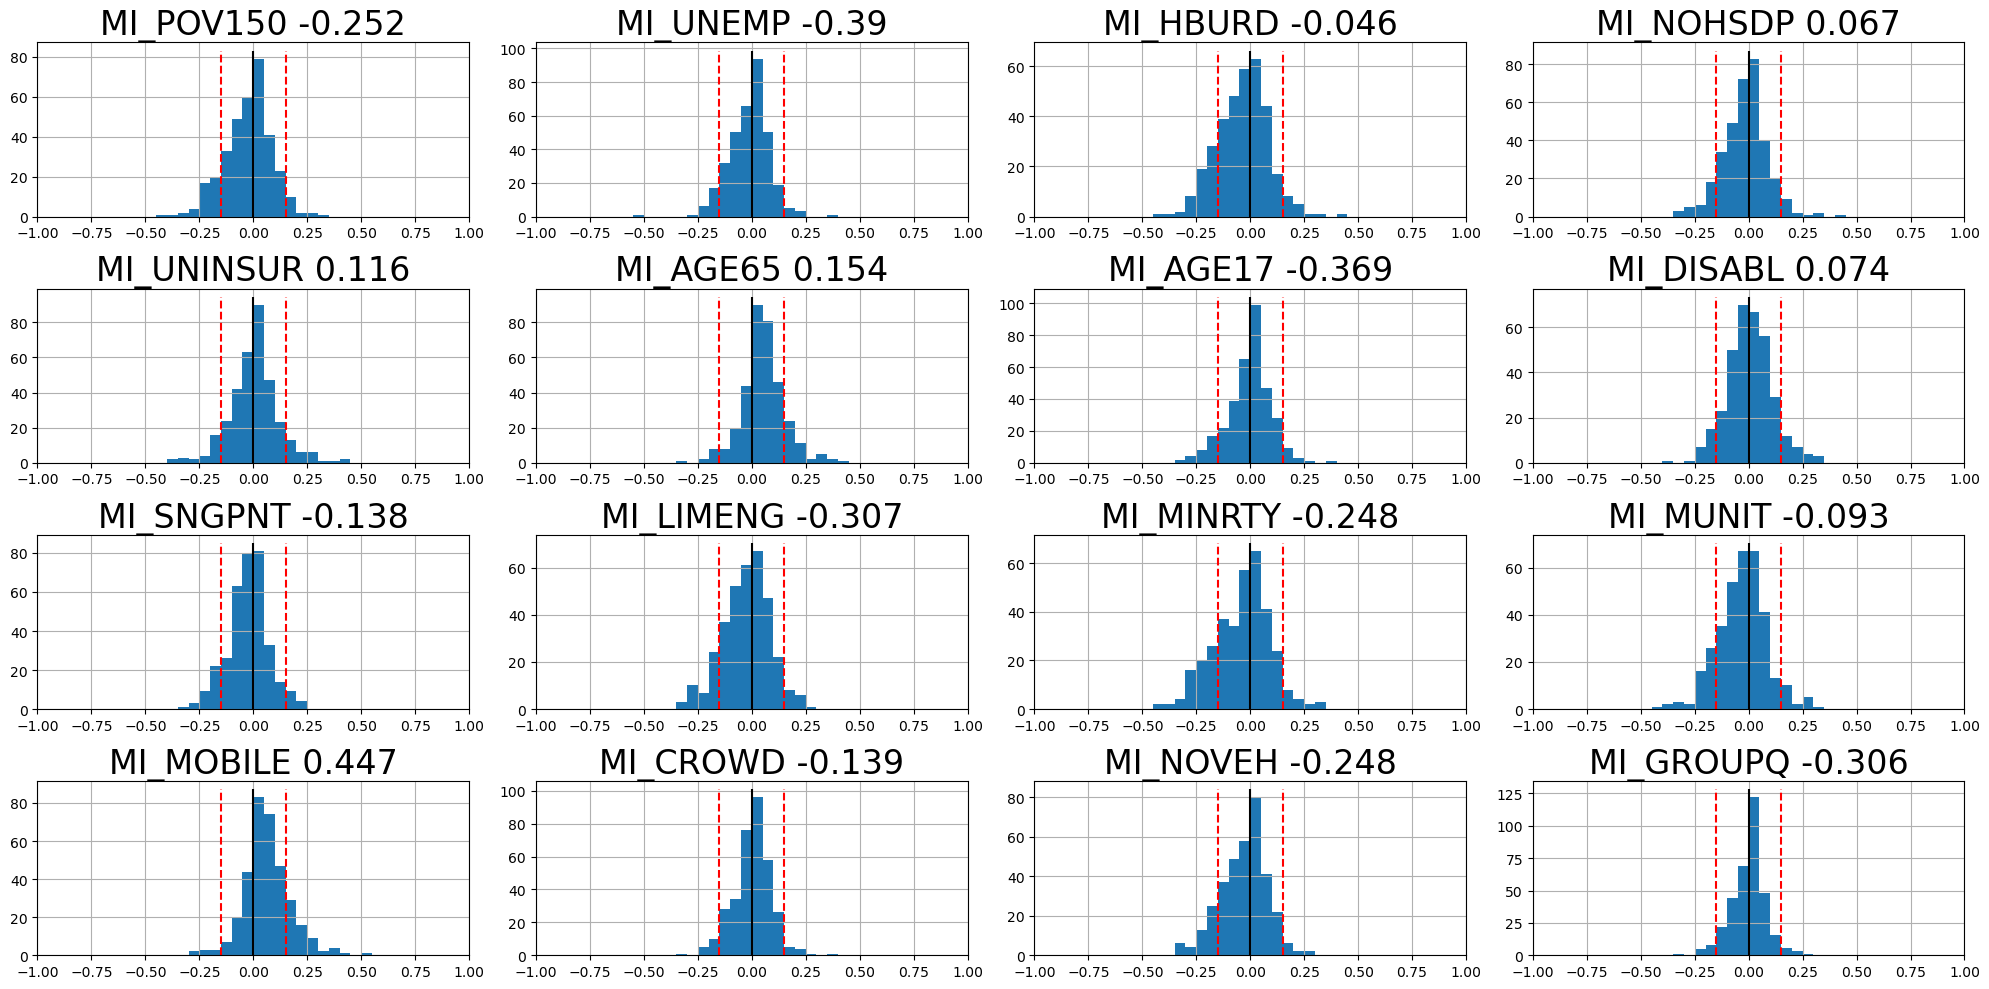

In [6]:
mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]

for col in mi_.columns:
    mi_ = mi_.loc[pd.notna(mi_[col])]
    
mi_

fig, axes = plt.subplots(4, 4, figsize=(20,10))
ax = axes.reshape(-1)

binwidth = 0.05
n = 10
for idx, col in enumerate(plot_cols_mi):
    bins = np.arange(math.floor(min(mi_[col]) * n) / n, math.ceil(max(mi_[col]) * n) / n + binwidth, binwidth)
    mi_[col].hist(ax=ax[idx], bins=bins)
    
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
#     ax[idx].vlines(mi_[col].mean(), 0, ylim, color='red')
    ax[idx].vlines(-0.15, 0, ylim, color='red', linestyle='dashed')
    ax[idx].vlines(0.15, 0, ylim, color='red', linestyle='dashed')
    
    skew_val = scipy.stats.skew(mi_[col])
    ax[idx].set_title(label=f"{col} {round(skew_val, 3)}", fontsize=24)
    ax[idx].set_xlim(-1, 1)
    
plt.tight_layout()
plt.show()
    

In [188]:
from sklearn.cluster import BisectingKMeans, KMeans

In [199]:
clusters.labels_

array([0, 1, 2, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2,
       0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 2, 0, 2, 0, 2, 0, 0, 1, 1, 0,
       2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2,
       0, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0,
       1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2,
       0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0, 2,
       2, 0, 0, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0,
       1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0,
       1, 0, 2, 2, 1, 0, 2, 2, 1, 1, 2, 0, 2, 0, 2,

In [200]:
mi_

MI_POV150  MI_UNEMP  MI_HBURD  MI_NOHSDP  MI_UNINSUR  MI_AGE65  MI_AGE17  \
0     0.015705 -0.017574  0.083044  -0.059295   -0.078009  0.033353  0.010902   
1     0.197722  0.226742  0.228896  -0.028454   -0.085629  0.126686 -0.128580   
2    -0.169999 -0.160956 -0.196013  -0.180554    0.027277  0.180915  0.032000   
3     0.181810  0.082801  0.180473   0.168056    0.105109 -0.155445  0.123823   
4     0.025983  0.034825 -0.062186   0.162110    0.112381 -0.191313  0.051426   
..         ...       ...       ...        ...         ...       ...       ...   
340   0.083641  0.013976  0.054407   0.031443   -0.077466  0.095964 -0.129570   
341  -0.073615 -0.053885 -0.087424  -0.045171    0.076487  0.080616  0.073809   
342  -0.181453 -0.087180 -0.206407  -0.220547   -0.141647  0.419107 -0.065566   
343   0.033715  0.057711  0.041060  -0.122407    0.008481 -0.069844  0.051737   
344   0.048514 -0.100838  0.212380   0.032367   -0.342003 -0.074578  0.225513   

     MI_DISABL  MI_SNGPNT  MI_LIMENG  MI_MINRTY  MI_MUNIT  MI_MOBILE  \
0     0.064272   0.025284  -0.121798  -0.009425  0.103823  -0.061876   
1    -0.005098   0.046259   0.112956   0.014687  0.138694   0.067236   
2    -0.219862  -0.183137  -0.183676  -0.261286 -0.216439   0.292983   
3     0.058082   0.239993   0.158026   0.281753  0.164588  -0.162967   
4    -0.022916  -0.026695   0.053645   0.083342 -0.142796   0.048700   
..         ...        ...        ...        ...       ...        ...   
340   0.053559   0.025072   0.088068  -0.048193  0.002125   0.036644   
341  -0.100923   0.054950   0.029311   0.026226 -0.034311   0.044175   
342   0.248452  -0.191892  -0.279891  -0.265601 -0.208911   0.353174   
343  -0.198194   0.074114  -0.031001   0.058621  0.002109  -0.025687   
344   0.162344   0.247114  -0.040253   0.170155  0.276367  -0.271757   

     MI_CROWD  MI_NOVEH  MI_GROUPQ  cluster  
0    0.017522  0.098574   0.004487        0  
1   -0.018645  0.076771   0.046384        1  
2   -0.054337 -0.266608   0.130085        2  
3    0.142658  0.112878   0.020701        1  
4    0.155419 -0.009343   0.238868        1  
..        ...       ...        ...      ...  
340  0.060479  0.028443   0.124544        0  
341  0.016625 -0.062923  -0.063345        0  
342 -0.020082 -0.167463  -0.149443        2  
343 -0.079626  0.052645  -0.000441        0  
344  0.252073 -0.118120   0.058367        1  

[345 rows x 17 columns]

In [201]:
clusters.labels_

array([0, 1, 2, 1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2,
       0, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 2, 0, 2, 0, 2, 0, 0, 1, 1, 0,
       2, 0, 0, 2, 1, 0, 2, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 0, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2,
       0, 1, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0,
       1, 1, 2, 1, 2, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 0, 2,
       0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 0, 2,
       2, 0, 0, 0, 2, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 0, 0, 2, 0, 2, 1, 0,
       1, 0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0,
       1, 0, 2, 2, 1, 0, 2, 2, 1, 1, 2, 0, 2, 0, 2,

In [304]:
# mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]
mi_ = mi[['MI_POV150',
 'MI_UNEMP',
 'MI_HBURD',
 'MI_NOHSDP',
 'MI_UNINSUR']]

pca_n = 2
pca_2 = PCA(n_components=pca_n)
pca_2_result = pca_2.fit_transform(mi_)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

# >> Explained variation per principal component: [0.36198848 0.1920749 ]

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))


Explained variation per principal component: [0.5504983  0.17916297]
Cumulative variance explained by 2 principal components: 72.97%


In [305]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=mi_.columns, index=[f'PC_{v}' for v in range(1, pca_n+1)])
print('\n\n', dataset_pca)



       MI_POV150  MI_UNEMP  MI_HBURD  MI_NOHSDP  MI_UNINSUR
PC_1   0.559270  0.333503  0.500428   0.416478    0.390014
PC_2   0.180554  0.261688  0.483175   0.336809    0.742981


In [306]:
pca_df = pd.DataFrame(pca_2_result, columns=[f"Component_{v+1}" for v in range(0, pca_n)])
mi_= pd.concat([mi_, pca_df], axis=1)
mi_

MI_POV150  MI_UNEMP  MI_HBURD  MI_NOHSDP  MI_UNINSUR  Component_1  \
0     0.015705 -0.017574  0.083044  -0.059295   -0.078009     0.030039   
1     0.197722  0.226742  0.228896  -0.028454   -0.085629     0.296176   
2    -0.169999 -0.160956 -0.196013  -0.180554    0.027277    -0.270725   
3     0.181810  0.082801  0.180473   0.168056    0.105109     0.371273   
4     0.025983  0.034825 -0.062186   0.162110    0.112381     0.147051   
..         ...       ...       ...        ...         ...          ...   
340   0.083641  0.013976  0.054407   0.031443   -0.077466     0.102227   
341  -0.073615 -0.053885 -0.087424  -0.045171    0.076487    -0.051194   
342  -0.181453 -0.087180 -0.206407  -0.220547   -0.141647    -0.340267   
343   0.033715  0.057711  0.041060  -0.122407    0.008481     0.051657   
344   0.048514 -0.100838  0.212380   0.032367   -0.342003     0.020556   

     Component_2  
0       0.139432  
1       0.301976  
2      -0.103837  
3       0.030138  
4      -0.131199  
..           ...  
340     0.115152  
341    -0.088108  
342     0.047357  
343     0.099096  
344     0.351328  

[345 rows x 7 columns]

In [307]:
print("\n*************** Most important features *************************")
for v in range(1, pca_n+1):
    print(f'As per PC {v}:\n', (dataset_pca[dataset_pca > 0.3].iloc[v-1]).dropna())   
# print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")




*************** Most important features *************************
As per PC 1:
 MI_POV150     0.559270
MI_UNEMP      0.333503
MI_HBURD      0.500428
MI_NOHSDP     0.416478
MI_UNINSUR    0.390014
Name: PC_1, dtype: float64
As per PC 2:
 MI_HBURD      0.483175
MI_NOHSDP     0.336809
MI_UNINSUR    0.742981
Name: PC_2, dtype: float64

******************************************************************


Parameter: {'n_clusters': 2} Score 0.3890605990179827
Parameter: {'n_clusters': 3} Score 0.3401369226878024
Parameter: {'n_clusters': 4} Score 0.3588439681902966


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


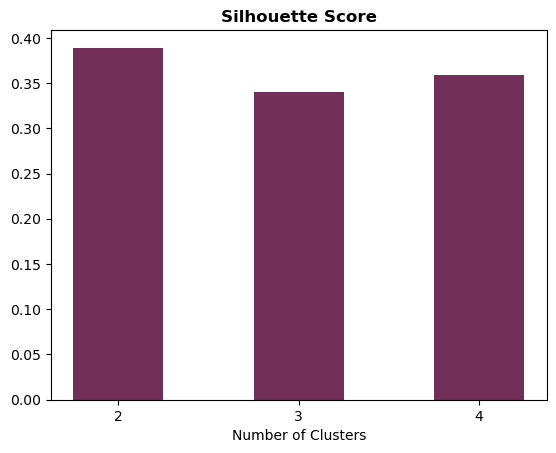

In [309]:
# candidate values for our number of cluster
parameters = list(range(2, 5))
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])          # fit model on wine dataset, this will find clusters based on parameter p
    ss = silhouette_score(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [310]:
dataset_pca

MI_POV150  MI_UNEMP  MI_HBURD  MI_NOHSDP  MI_UNINSUR
PC_1   0.559270  0.333503  0.500428   0.416478    0.390014
PC_2   0.180554  0.261688  0.483175   0.336809    0.742981

In [262]:
kmeans.labels_

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,

In [313]:
mi_[[f"Component_{v+1}" for v in range(0, pca_n)]]

Component_1  Component_2
0       0.030039     0.139432
1       0.296176     0.301976
2      -0.270725    -0.103837
3       0.371273     0.030138
4       0.147051    -0.131199
..           ...          ...
340     0.102227     0.115152
341    -0.051194    -0.088108
342    -0.340267     0.047357
343     0.051657     0.099096
344     0.020556     0.351328

[345 rows x 2 columns]

In [318]:
i = 2
# mi_ = mi[[col for col in mi.columns if col.startswith('MI')]].T
# mi_
clusters = BisectingKMeans(n_clusters=i, random_state=17).fit(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])
mi_['cluster'] = clusters.labels_
silhouette = silhouette_score(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], clusters.labels_, random_state=17)
silhouette

0.3882692420903844

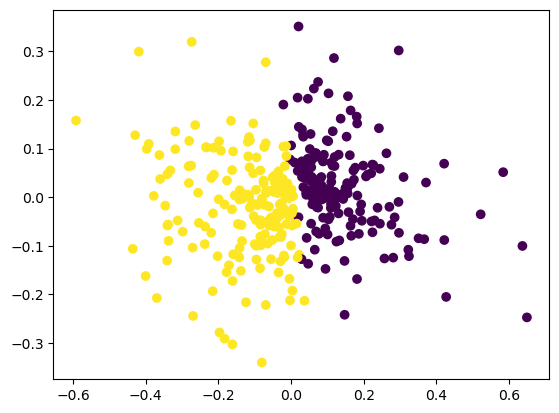

In [322]:
plt.scatter(mi_['Component_1'], mi_['Component_2'], c=mi_['cluster'])

In [323]:
mi_.columns

Index(['MI_POV150', 'MI_UNEMP', 'MI_HBURD', 'MI_NOHSDP', 'MI_UNINSUR',
       'Component_1', 'Component_2', 'cluster'],
      dtype='object')

52.1875
55.625


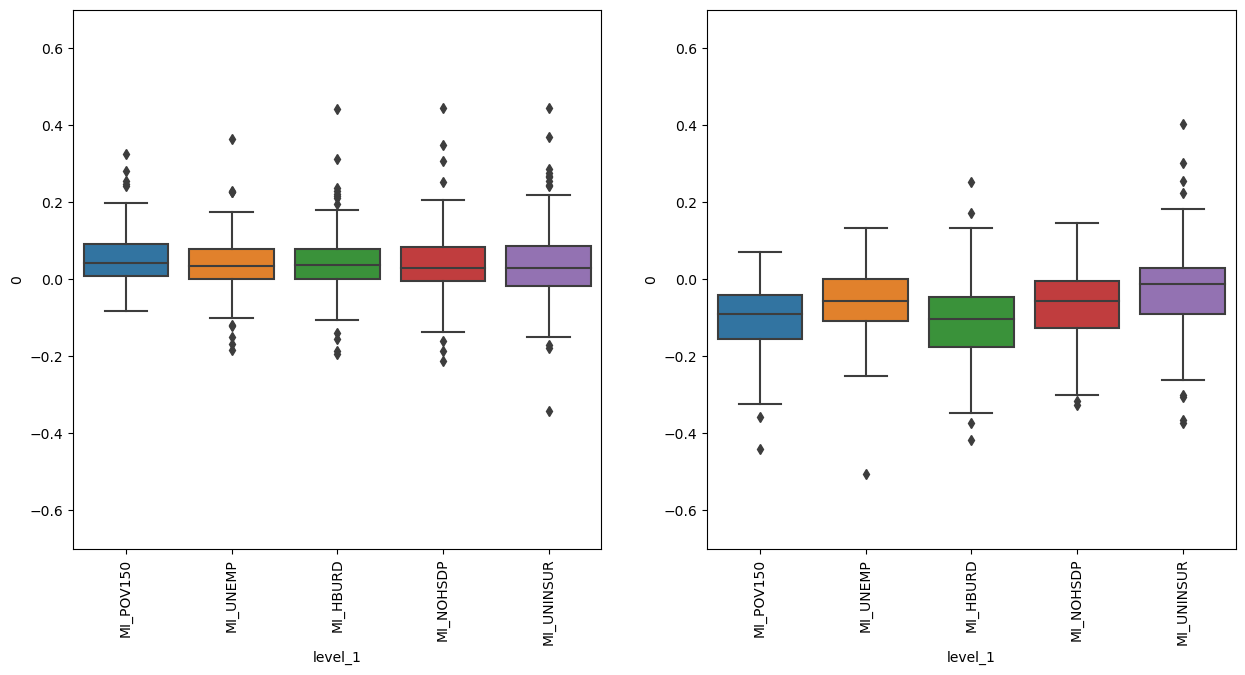

In [325]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        
for c in range(2):
    temp_cluster = mi_.loc[mi_['cluster'] == c, ['MI_POV150', 'MI_UNEMP', 'MI_HBURD', 'MI_NOHSDP', 'MI_UNINSUR']].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
    ax[c].set_ylim(-0.7, 0.7)
    ax[c].set_xticklabels([col for col in mi_.columns if col.startswith('MI')], rotation = 'vertical')

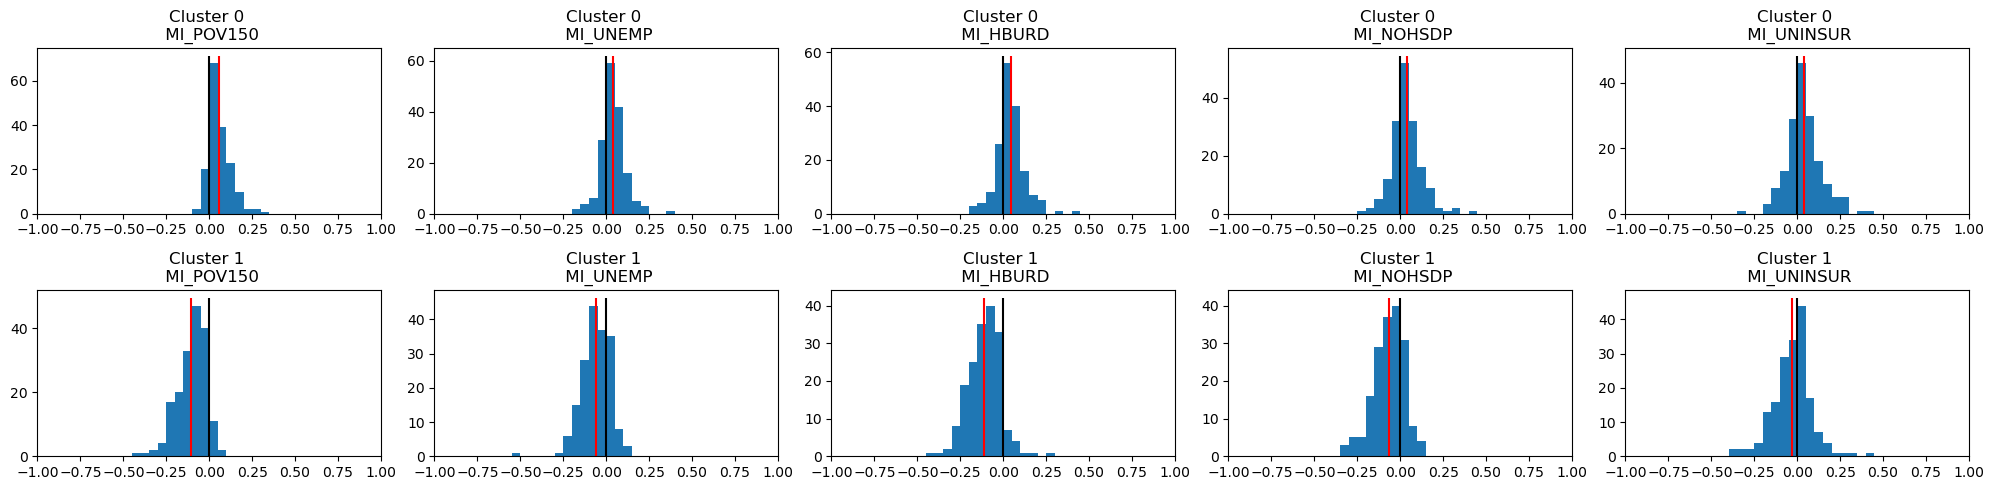

In [379]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    
binwidth = 0.05
n = 10
for c in range(2):
    for col_idx, col in enumerate(['MI_POV150', 'MI_UNEMP', 'MI_HBURD', 'MI_NOHSDP', 'MI_UNINSUR']):
        temp_cluster_ = mi_.loc[mi_['cluster'] == c, [col]].values
        bins = np.arange(math.floor(min(temp_cluster_) * n) / n, math.ceil(max(temp_cluster_) * n) / n + binwidth, binwidth)
        axes[c, col_idx].hist(temp_cluster_, bins=bins)
        axes[c, col_idx].set_xlim(-1, 1)
        
        ylim = axes[c, col_idx].get_ylim()[1]
        axes[c, col_idx].vlines(0, 0, ylim, color='black')
        axes[c, col_idx].vlines(temp_cluster_.mean(), 0, ylim, color='red')
        axes[c, col_idx].set_title(f"Cluster {c} \n {col}")
plt.tight_layout()


## PCA Household Characteristics

In [388]:
# mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]
mi_ = mi[['MI_AGE65', 'MI_AGE17', 'MI_DISABL', 'MI_SNGPNT', 'MI_LIMENG']]

pca_n = 2
pca_2 = PCA(n_components=pca_n)
pca_2_result = pca_2.fit_transform(mi_)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))

print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))


Explained variation per principal component: [0.40930161 0.22142878]
Cumulative variance explained by 2 principal components: 63.07%


In [389]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=mi_.columns, index=[f'PC_{v}' for v in range(1, pca_n+1)])
print('\n\n', dataset_pca)



       MI_AGE65  MI_AGE17  MI_DISABL  MI_SNGPNT  MI_LIMENG
PC_1  0.562958  0.388143   0.226798   0.410342   0.559112
PC_2  0.113038  0.010611   0.913655   0.281198   0.270688


In [390]:
pca_df = pd.DataFrame(pca_2_result, columns=[f"Component_{v+1}" for v in range(0, pca_n)])
mi_= pd.concat([mi_, pca_df], axis=1)
mi_

MI_AGE65  MI_AGE17  MI_DISABL  MI_SNGPNT  MI_LIMENG  Component_1  \
0    0.033353  0.010902   0.064272   0.025284  -0.121798    -0.027273   
1    0.126686 -0.128580  -0.005098   0.046259   0.112956     0.021638   
2    0.180915  0.032000  -0.219862  -0.183137  -0.183676    -0.157835   
3   -0.155445  0.123823   0.058082   0.239993   0.158026     0.368802   
4   -0.191313  0.051426  -0.022916  -0.026695   0.053645     0.211470   
..        ...       ...        ...        ...        ...          ...   
340  0.095964 -0.129570   0.053559   0.025072   0.088068     0.002637   
341  0.080616  0.073809  -0.100923   0.054950   0.029311     0.104662   
342  0.419107 -0.065566   0.248452  -0.191892  -0.279891    -0.493397   
343 -0.069844  0.051737  -0.198194   0.074114  -0.031001     0.177001   
344 -0.074578  0.225513   0.162344   0.247114  -0.040253     0.231163   

     Component_2  
0      -0.037740  
1      -0.052874  
2       0.280314  
3      -0.148062  
4       0.034011  
..           ...  
340    -0.090288  
341     0.057935  
342    -0.144947  
343     0.174986  
344    -0.201872  

[345 rows x 7 columns]

In [391]:
print("\n*************** Most important features *************************")
for v in range(1, pca_n+1):
    print(f'As per PC {v}:\n', (dataset_pca[dataset_pca > 0.3].iloc[v-1]).dropna())   
# print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")




*************** Most important features *************************
As per PC 1:
 MI_AGE65     0.562958
MI_AGE17     0.388143
MI_SNGPNT    0.410342
MI_LIMENG    0.559112
Name: PC_1, dtype: float64
As per PC 2:
 MI_DISABL    0.913655
Name: PC_2, dtype: float64

******************************************************************


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

Parameter: {'n_clusters': 2} Score 0.3714628488122809
Parameter: {'n_clusters': 3} Score 0.2924332903656741
Parameter: {'n_clusters': 4} Score 0.3113974706967018
Parameter: {'n_clusters': 5} Score 0.3203308915270213
Parameter: {'n_clusters': 6} Score 0.3271343476233995
Parameter: {'n_clusters': 7} Score 0.3422974964269217


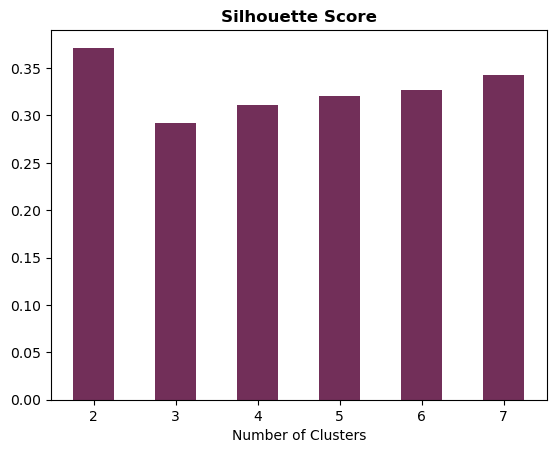

In [394]:
# candidate values for our number of cluster
parameters = list(range(2, 8))
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])          # fit model on wine dataset, this will find clusters based on parameter p
    ss = silhouette_score(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [393]:
i = 2
# mi_ = mi[[col for col in mi.columns if col.startswith('MI')]].T
# mi_
clusters = BisectingKMeans(n_clusters=i, random_state=17).fit(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])
mi_['cluster'] = clusters.labels_
silhouette = silhouette_score(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], clusters.labels_, random_state=17)
silhouette

0.3631375002975785

42.1875
65.625


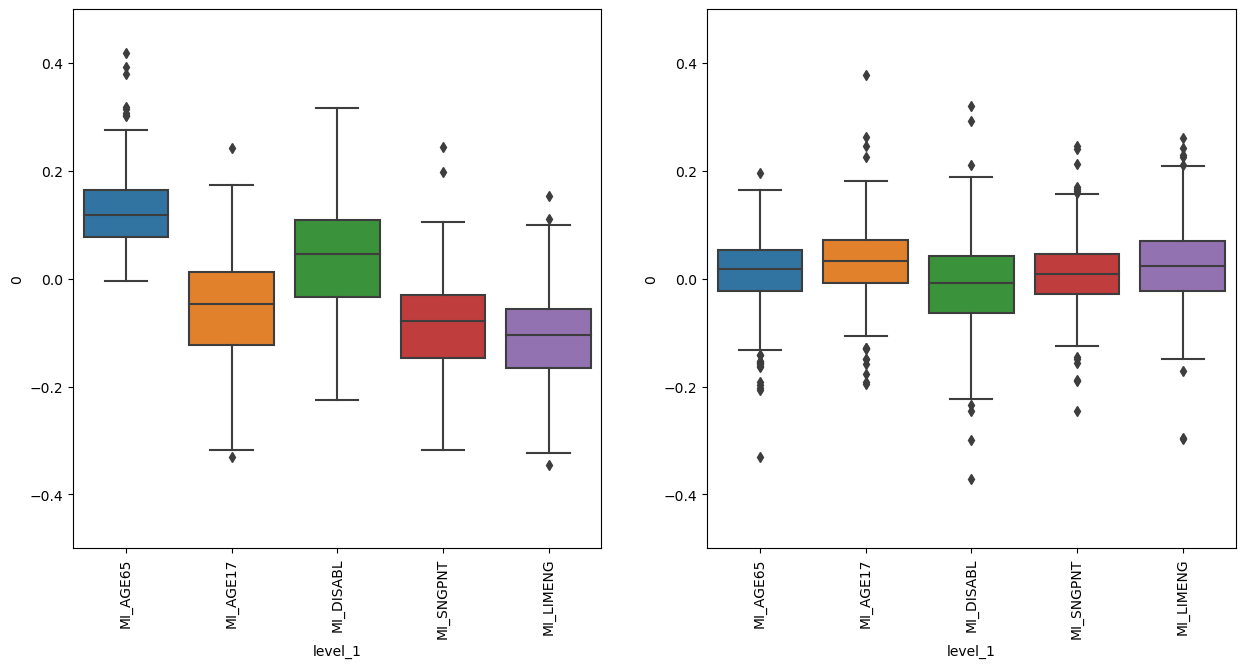

In [395]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        
for c in range(2):
    
    temp_cluster = mi_.loc[mi_['cluster'] == c, [col for col in mi_.columns if col.startswith('MI')]].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
    ax[c].set_ylim(-0.5, 0.5)
    ax[c].set_xticklabels([col for col in mi_.columns if col.startswith('MI')], rotation = 'vertical')

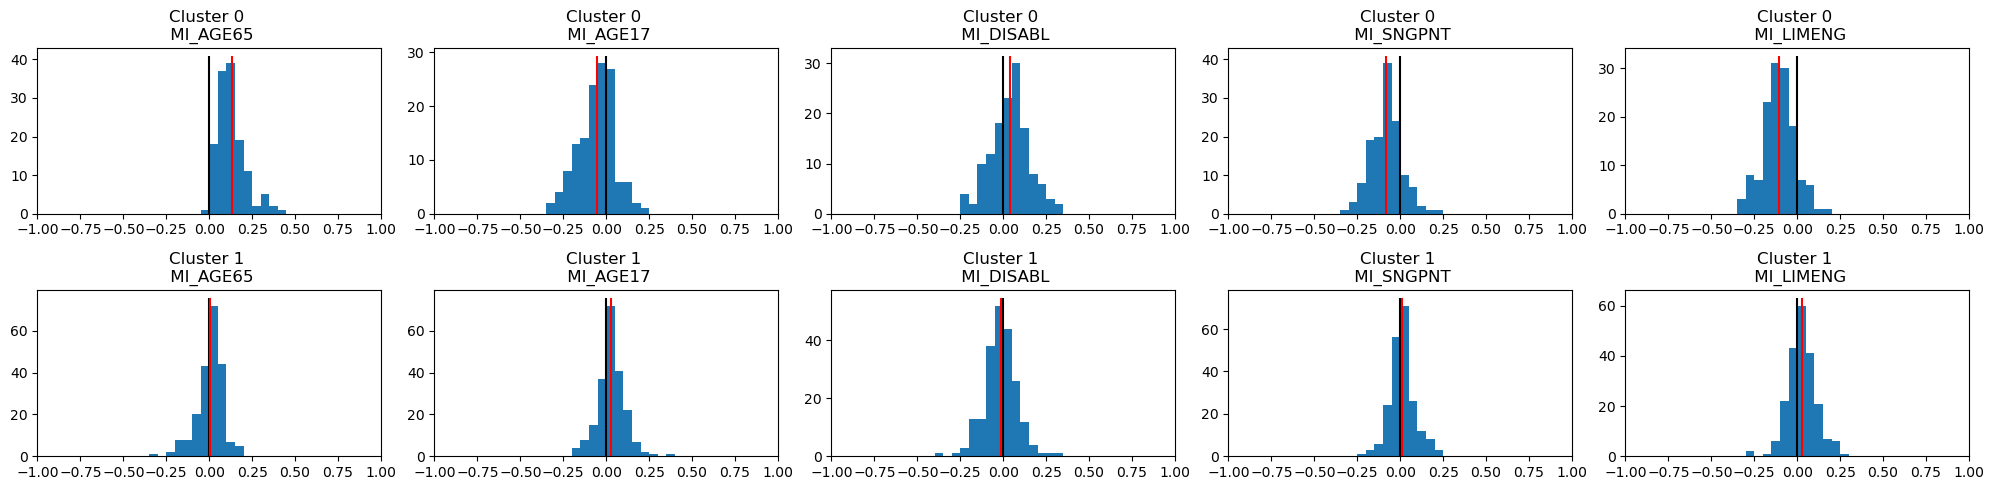

In [398]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    
binwidth = 0.05
n = 10
for c in range(2):
    for col_idx, col in enumerate([col for col in mi_.columns if col.startswith('MI')]):
        temp_cluster_ = mi_.loc[mi_['cluster'] == c, [col]].values
        bins = np.arange(math.floor(min(temp_cluster_) * n) / n, math.ceil(max(temp_cluster_) * n) / n + binwidth, binwidth)
        axes[c, col_idx].hist(temp_cluster_, bins=bins)
        axes[c, col_idx].set_xlim(-1, 1)
        
        ylim = axes[c, col_idx].get_ylim()[1]
        axes[c, col_idx].vlines(0, 0, ylim, color='black')
        axes[c, col_idx].vlines(temp_cluster_.mean(), 0, ylim, color='red')
        axes[c, col_idx].set_title(f"Cluster {c} \n {col}")
plt.tight_layout()


## PCA for Housing Type and Tranposrtation

In [402]:
# mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]
mi_ = mi[['MI_MUNIT', 'MI_MOBILE', 'MI_CROWD', 'MI_NOVEH', 'MI_GROUPQ']]

pca_n = 2
pca_2 = PCA(n_components=pca_n)
pca_2_result = pca_2.fit_transform(mi_)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))


Explained variation per principal component: [0.47475942 0.21174235]
Cumulative variance explained by 2 principal components: 68.65%


In [403]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=mi_.columns, index=[f'PC_{v}' for v in range(1, pca_n+1)])
print('\n\n', dataset_pca)

pca_df = pd.DataFrame(pca_2_result, columns=[f"Component_{v+1}" for v in range(0, pca_n)])
mi_= pd.concat([mi_, pca_df], axis=1)
mi_

print("\n*************** Most important features *************************")
for v in range(1, pca_n+1):
    print(f'As per PC {v}:\n', (dataset_pca[dataset_pca > 0.3].iloc[v-1]).dropna())   
# print('\n\nAs per PC 2:\n', (dataset_pca[dataset_pca > 0.3].iloc[1]).dropna())
print("\n******************************************************************")





       MI_MUNIT  MI_MOBILE  MI_CROWD  MI_NOVEH  MI_GROUPQ
PC_1  0.642522   0.463423  0.126353  0.544152   0.245638
PC_2  0.095422   0.714972  0.602388  0.252199   0.230726

*************** Most important features *************************
As per PC 1:
 MI_MUNIT     0.642522
MI_MOBILE    0.463423
MI_NOVEH     0.544152
Name: PC_1, dtype: float64
As per PC 2:
 MI_MOBILE    0.714972
MI_CROWD     0.602388
Name: PC_2, dtype: float64

******************************************************************


/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/jparkgeo/opt/anaconda3/envs/agingdam/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

Parameter: {'n_clusters': 2} Score 0.3943570744710988
Parameter: {'n_clusters': 3} Score 0.3030344549870543
Parameter: {'n_clusters': 4} Score 0.31460696844061903
Parameter: {'n_clusters': 5} Score 0.32422980280327107
Parameter: {'n_clusters': 6} Score 0.33859530851743247
Parameter: {'n_clusters': 7} Score 0.36156156328424566


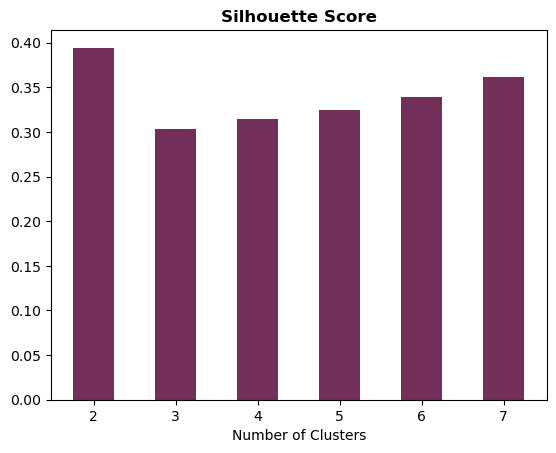

In [404]:
# candidate values for our number of cluster
parameters = list(range(2, 8))
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans()     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])          # fit model on wine dataset, this will find clusters based on parameter p
    ss = silhouette_score(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [405]:
i = 2
# mi_ = mi[[col for col in mi.columns if col.startswith('MI')]].T
# mi_
clusters = BisectingKMeans(n_clusters=i, random_state=17).fit(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])
mi_['cluster'] = clusters.labels_
silhouette = silhouette_score(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], clusters.labels_, random_state=17)
silhouette

0.3837387061626274

62.8125
45.0


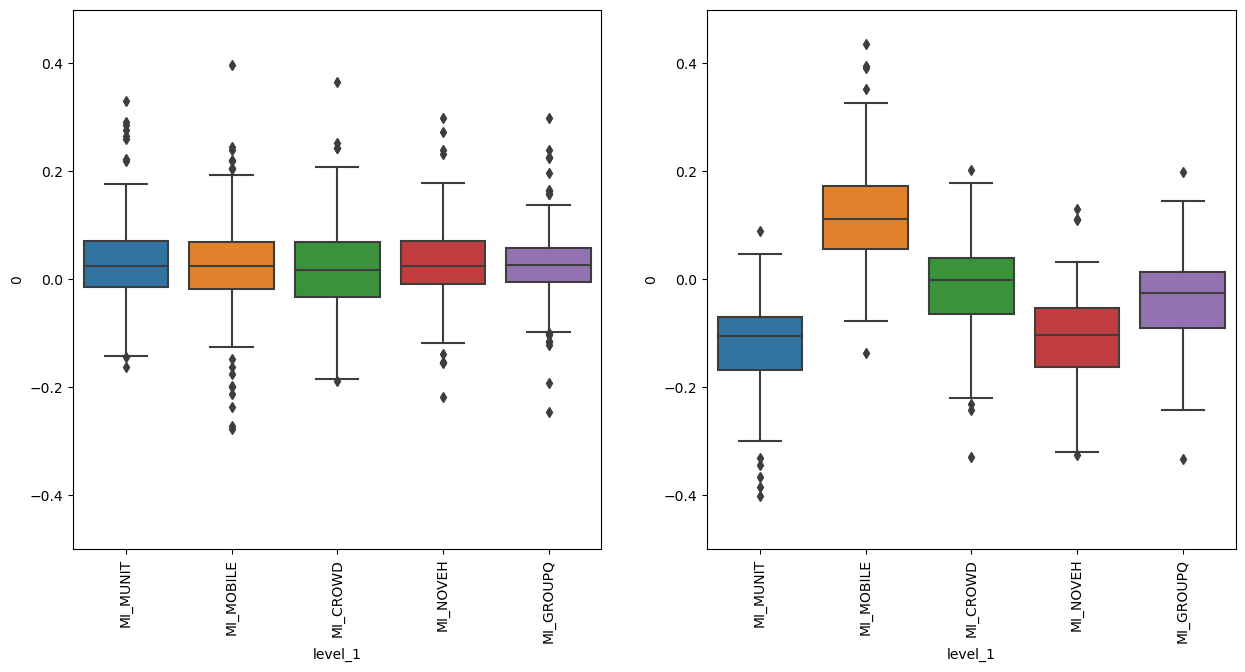

In [407]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        
for c in range(2):
    
    temp_cluster = mi_.loc[mi_['cluster'] == c, [col for col in mi_.columns if col.startswith('MI')]].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
    ax[c].set_ylim(-0.5, 0.5)
    ax[c].set_xticklabels([col for col in mi_.columns if col.startswith('MI')], rotation = 'vertical')

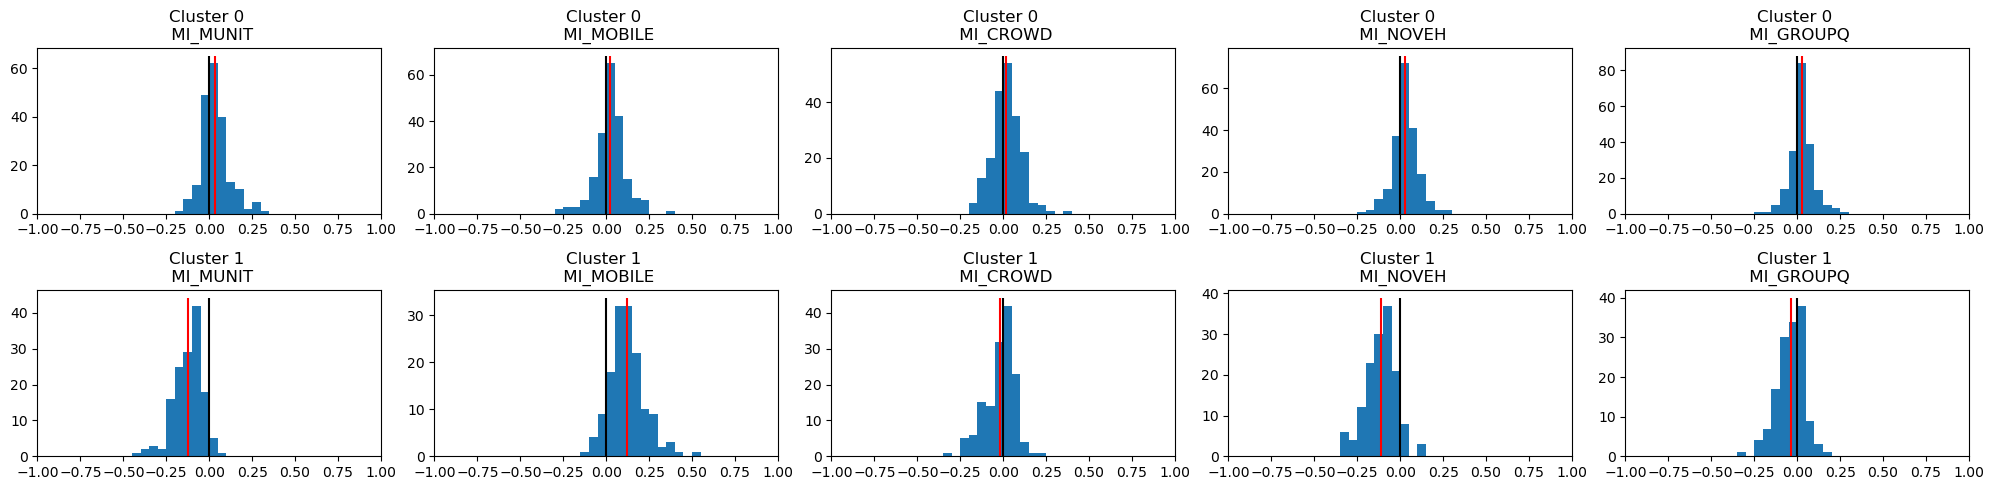

In [406]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5))
    
binwidth = 0.05
n = 10
for c in range(2):
    for col_idx, col in enumerate([col for col in mi_.columns if col.startswith('MI')]):
        temp_cluster_ = mi_.loc[mi_['cluster'] == c, [col]].values
        bins = np.arange(math.floor(min(temp_cluster_) * n) / n, math.ceil(max(temp_cluster_) * n) / n + binwidth, binwidth)
        axes[c, col_idx].hist(temp_cluster_, bins=bins)
        axes[c, col_idx].set_xlim(-1, 1)
        
        ylim = axes[c, col_idx].get_ylim()[1]
        axes[c, col_idx].vlines(0, 0, ylim, color='black')
        axes[c, col_idx].vlines(temp_cluster_.mean(), 0, ylim, color='red')
        axes[c, col_idx].set_title(f"Cluster {c} \n {col}")
plt.tight_layout()


## PCA for all

In [31]:
mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]
# mi_ = mi[['MI_MUNIT', 'MI_MOBILE', 'MI_CROWD', 'MI_NOVEH', 'MI_GROUPQ']]

pca_n = 4
pca_2 = PCA(n_components=pca_n)
pca_2_result = pca_2.fit_transform(mi_)
print('Explained variation per principal component: {}'.format(pca_2.explained_variance_ratio_))
print('Cumulative variance explained by 2 principal components: {:.2%}'.format(np.sum(pca_2.explained_variance_ratio_)))


Explained variation per principal component: [0.38041092 0.12823956 0.1070004  0.07490494]
Cumulative variance explained by 2 principal components: 69.06%


In [32]:
# Results from pca.components_
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=mi_.columns, index=[f'PC_{v}' for v in range(1, pca_n+1)])
print('\n\n', dataset_pca)

pca_df = pd.DataFrame(pca_2_result, columns=[f"Component_{v+1}" for v in range(0, pca_n)])
mi_= pd.concat([mi_, pca_df], axis=1)
mi_

print("\n*************** Most important features *************************")
for v in range(1, pca_n+1):
    print(f'As per PC {v}:\n', (dataset_pca[dataset_pca > 0.3].iloc[v-1]).dropna())   
print("\n******************************************************************")





       MI_POV150  MI_UNEMP  MI_HBURD  MI_NOHSDP  MI_UNINSUR  MI_AGE65  \
PC_1   0.339409  0.180406  0.362127   0.241479    0.228747  0.228978   
PC_2   0.285442  0.238220  0.075436   0.341534    0.243642  0.205921   
PC_3   0.128058  0.133255  0.318451   0.247431    0.221562  0.287905   
PC_4   0.203433  0.172108  0.009531   0.105938    0.459172  0.180253   

      MI_AGE17  MI_DISABL  MI_SNGPNT  MI_LIMENG  MI_MINRTY  MI_MUNIT  \
PC_1  0.039004   0.059943   0.221882   0.301931   0.409430  0.292294   
PC_2  0.013454   0.486899   0.056656   0.066237   0.172811  0.302377   
PC_3  0.406157   0.347021   0.029780   0.297208   0.184882  0.182605   
PC_4  0.606693   0.119736   0.316754   0.153139   0.185972  0.188597   

      MI_MOBILE  MI_CROWD  MI_NOVEH  MI_GROUPQ  
PC_1   0.132660  0.164639  0.307161   0.142906  
PC_2   0.510295  0.097764  0.015618   0.036414  
PC_3   0.222334  0.242666  0.311079   0.154952  
PC_4   0.229748  0.151638  0.094150   0.115568  

*************** Most importan

Parameter: {'n_clusters': 2} Score 0.30026282361177753
Parameter: {'n_clusters': 3} Score 0.21291269203125268
Parameter: {'n_clusters': 4} Score 0.2132025663169982
Parameter: {'n_clusters': 5} Score 0.20070919863980083
Parameter: {'n_clusters': 6} Score 0.2014624124357902
Parameter: {'n_clusters': 7} Score 0.18012445061300794
Parameter: {'n_clusters': 8} Score 0.1840128702792794
Parameter: {'n_clusters': 9} Score 0.19013052541573827
Parameter: {'n_clusters': 10} Score 0.18216307508158452
Parameter: {'n_clusters': 11} Score 0.18544940803974844
Parameter: {'n_clusters': 12} Score 0.18611651393755643
Parameter: {'n_clusters': 13} Score 0.18317016266073108
Parameter: {'n_clusters': 14} Score 0.18446635318328064
Parameter: {'n_clusters': 15} Score 0.19990493940951326
Parameter: {'n_clusters': 16} Score 0.18987767127720837
Parameter: {'n_clusters': 17} Score 0.1990948634131731
Parameter: {'n_clusters': 18} Score 0.2119463411254307
Parameter: {'n_clusters': 19} Score 0.20924333939951917


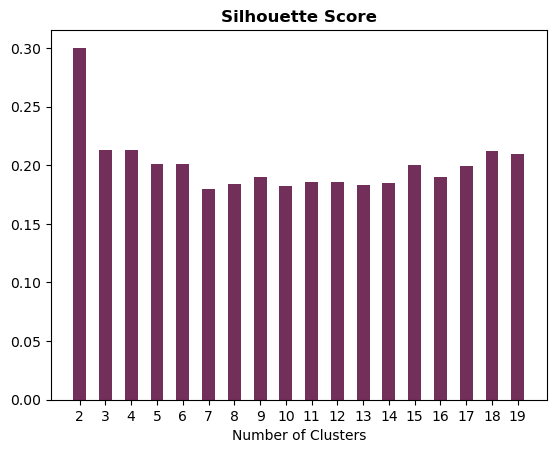

In [33]:
# candidate values for our number of cluster
parameters = list(range(2, 20))
# instantiating ParameterGrid, pass number of clusters as input
parameter_grid = ParameterGrid({'n_clusters': parameters})
best_score = -1
kmeans_model = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)     # instantiating KMeans model
silhouette_scores = []
# evaluation based on silhouette_score
for p in parameter_grid:
    kmeans_model.set_params(**p)    # set current hyper parameter
    kmeans_model.fit(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])          # fit model on wine dataset, this will find clusters based on parameter p
    ss = silhouette_score(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], kmeans_model.labels_)   # calculate silhouette_score
    silhouette_scores += [ss]       # store all the scores
    print('Parameter:', p, 'Score', ss)
    # check p which has the best score
    if ss > best_score:
        best_score = ss
        best_grid = p
# plotting silhouette score
plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
plt.xticks(range(len(silhouette_scores)), list(parameters))
plt.title('Silhouette Score', fontweight='bold')
plt.xlabel('Number of Clusters')
plt.show()

In [34]:
mi_[[f"Component_{v+1}" for v in range(0, pca_n)]]

Component_1  Component_2  Component_3  Component_4
0      -0.128908    -0.114387    -0.190291    -0.097694
1      -0.334120     0.009095    -0.257404    -0.000953
2       0.531021     0.025261     0.142390     0.139944
3      -0.692557    -0.106451     0.076455    -0.152902
4      -0.249788     0.072441     0.224103    -0.003229
..           ...          ...          ...          ...
340    -0.156204     0.032902    -0.133553     0.026655
341    -0.003703    -0.090108     0.148985     0.010597
342     0.646333     0.292065    -0.177568     0.068242
343    -0.148205    -0.218833     0.010781    -0.091018
344    -0.377968    -0.325984    -0.074339    -0.358998

[345 rows x 4 columns]

In [35]:
def determine_number_of_cluster(array):
    km_cost = []  # Sum of squared distances of samples to their closest cluster center.
    distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
    km_silhouette = {}

    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)
        KM.fit(array)

        # Calculate Silhouette Scores
        preds = KM.predict(array)
        silhouette = silhouette_score(array, preds)
        km_silhouette[i] = silhouette

#     print(max(km_silhouette, key=km_silhouette.get))
#     print(km_silhouette)
        
    return km_silhouette


def kmeans_cluster(array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster, max_iter=999, n_init = 99, random_state=17)
    kmeans.fit(array)
    y_kmeans = kmeans.predict(array)
    
    cluster_df = pd.DataFrame({'cluster': y_kmeans}, index=array.index)
    
    return cluster_df


determine_number_of_cluster(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]])
# mi_copy = mi_.copy(deep=True)
mi_copy = kmeans_cluster(mi_[[f"Component_{v+1}" for v in range(0, pca_n)]], 4)


In [38]:
mi_['cluster'] = mi_copy['cluster']

72.0
82.0
49.0
142.0


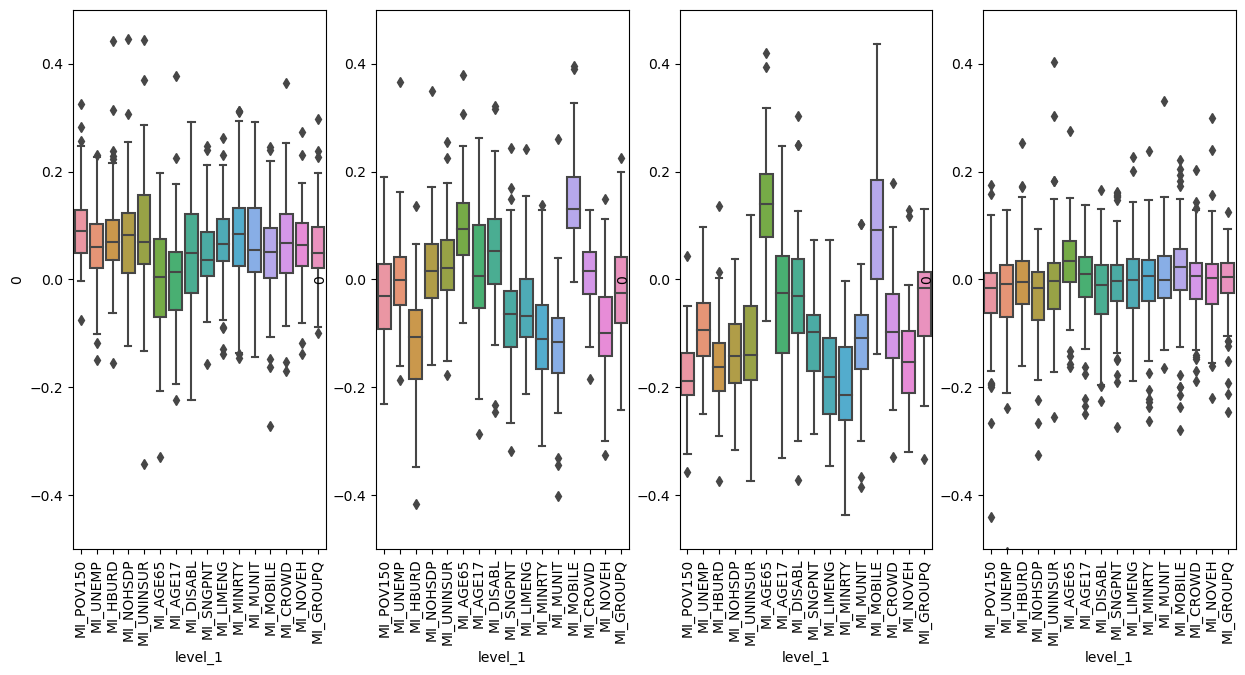

In [41]:
fig, ax = plt.subplots(1, 4, figsize=(15, 7))
        
for c in range(4):
    temp_cluster = mi_.loc[mi_['cluster'] == c, [col for col in mi_.columns if col.startswith('MI')]].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
    ax[c].set_ylim(-0.5, 0.5)
    ax[c].set_xticklabels([col for col in mi_.columns if col.startswith('MI')], rotation = 'vertical')

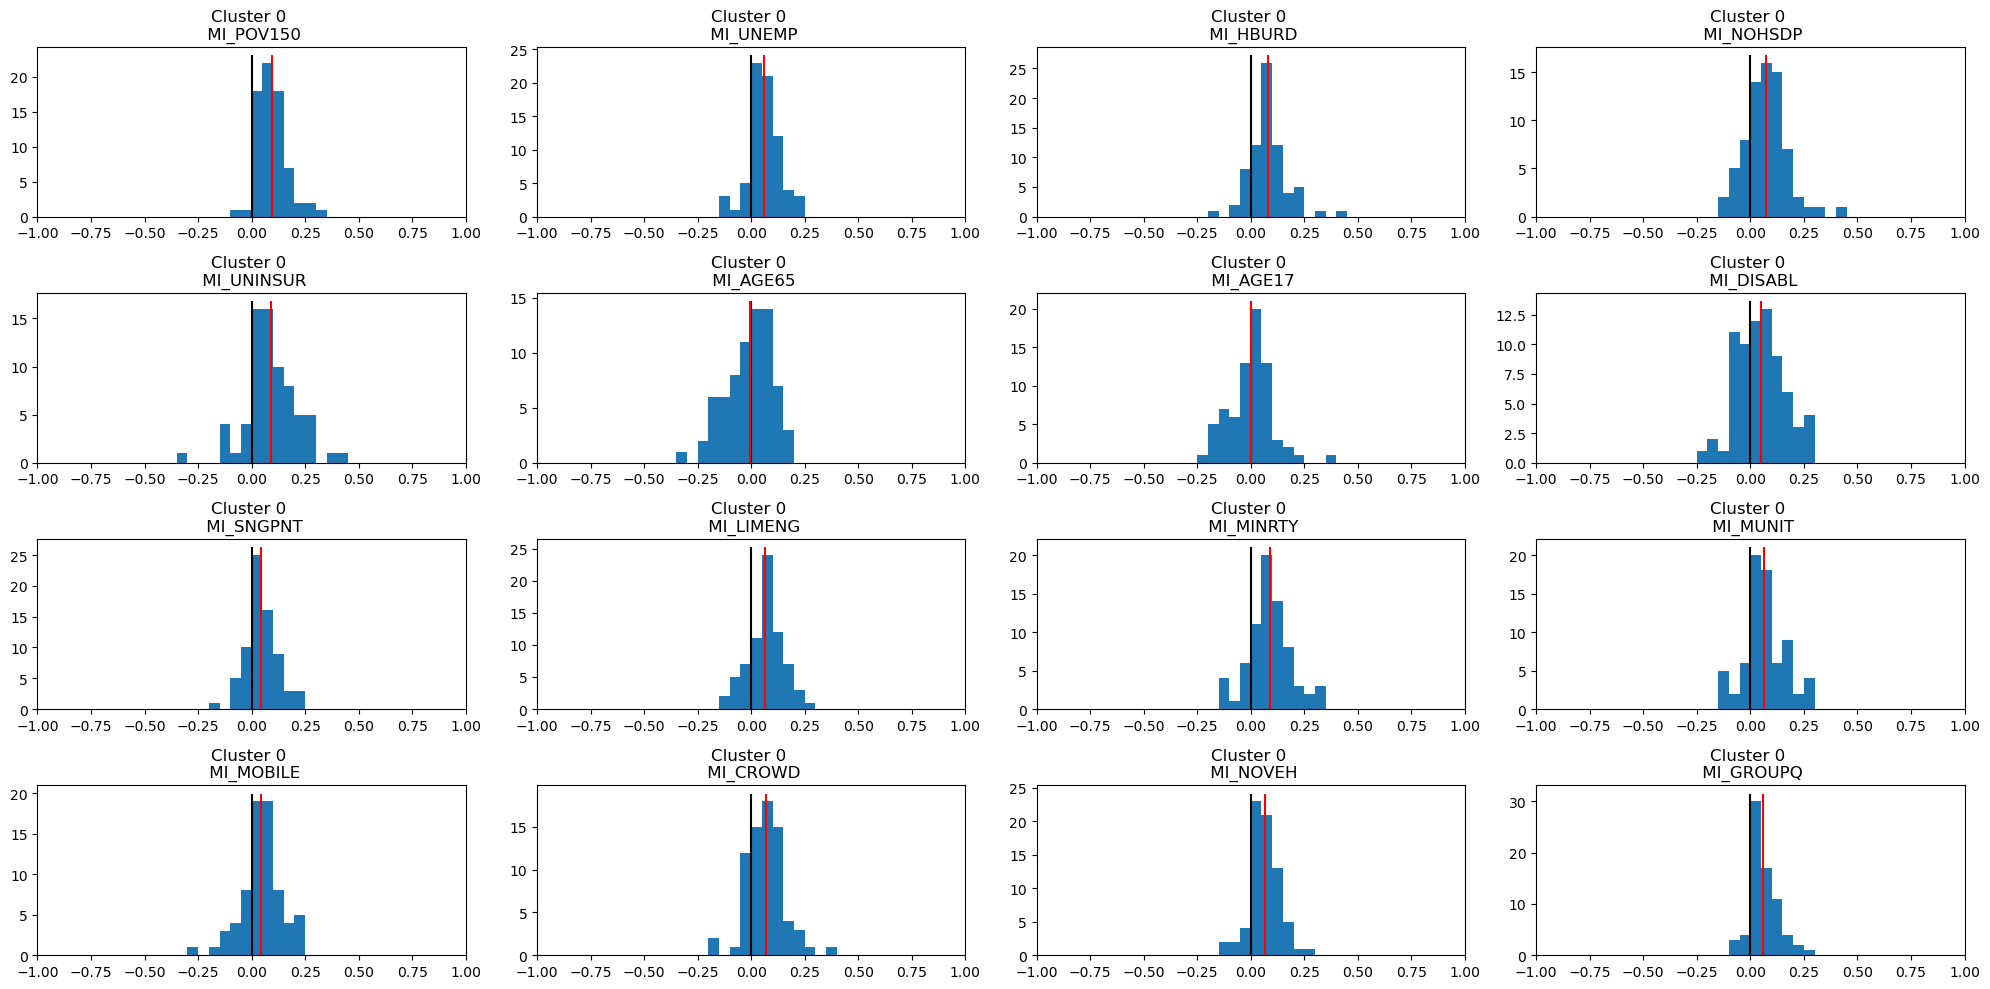

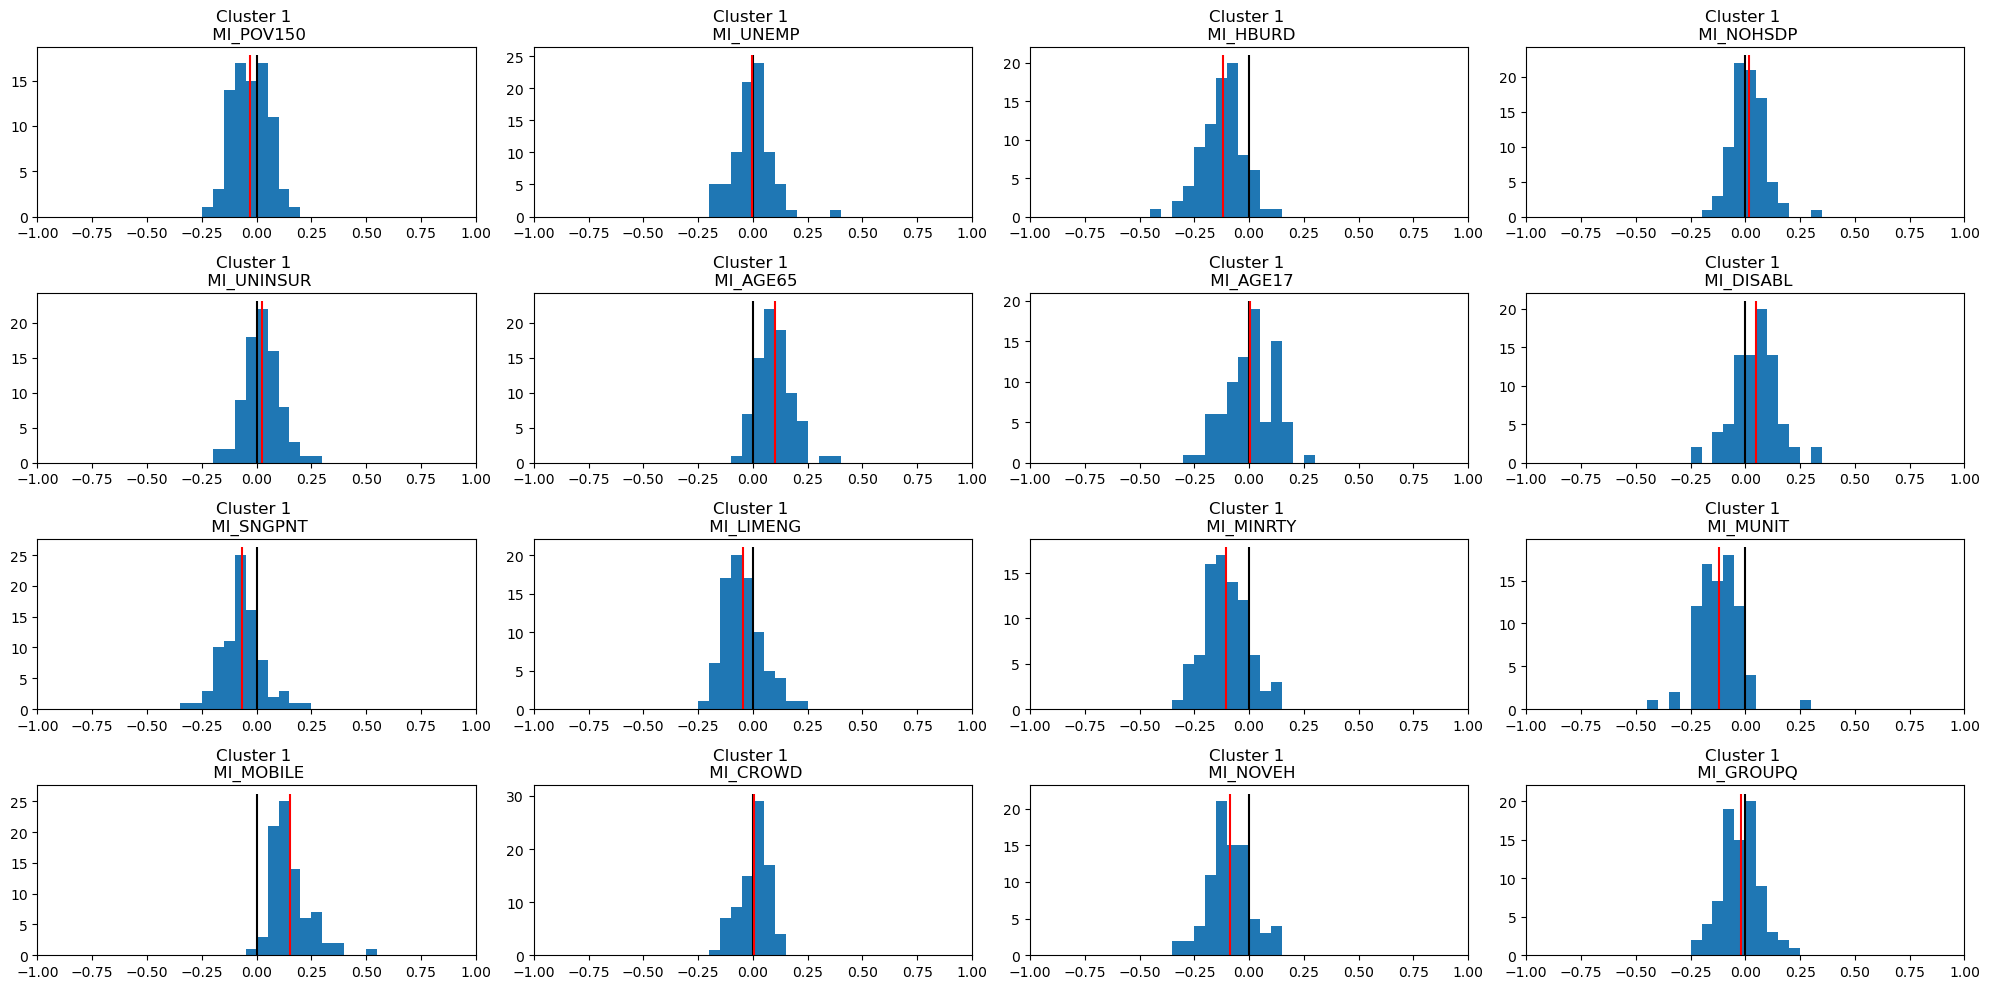

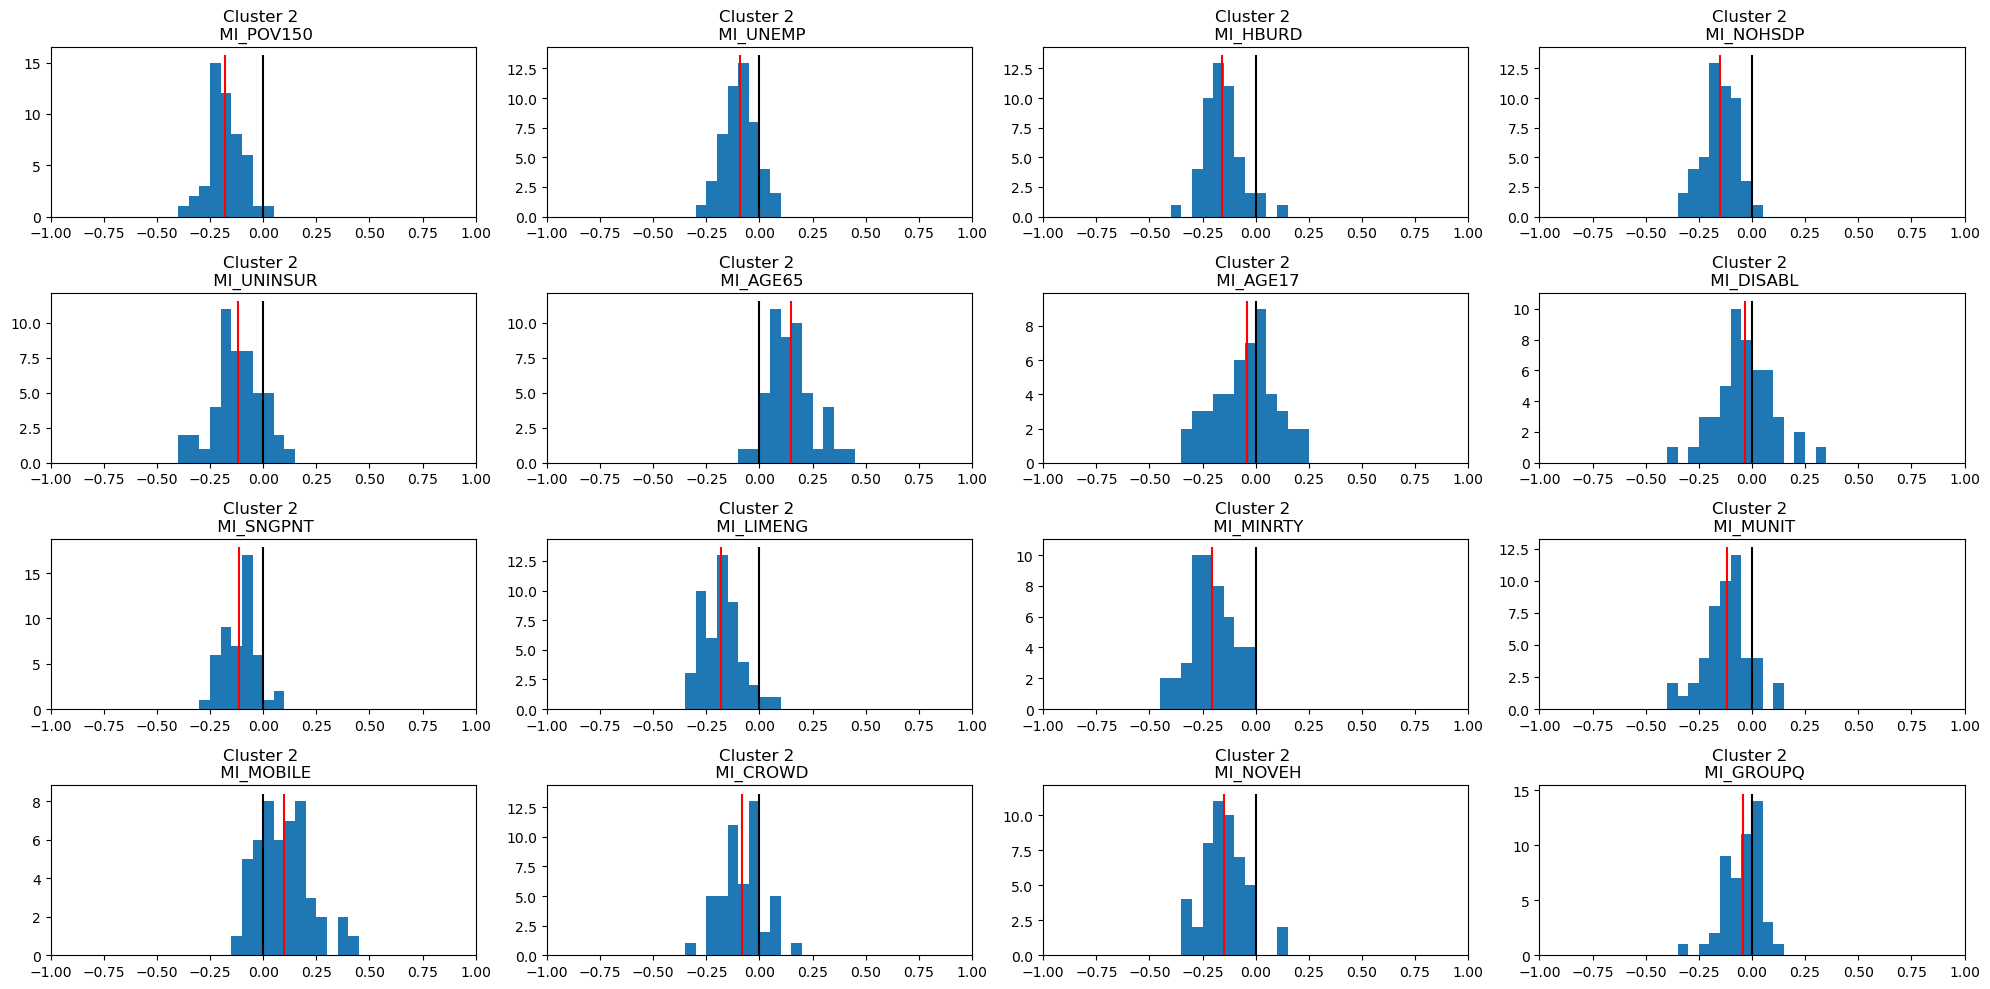

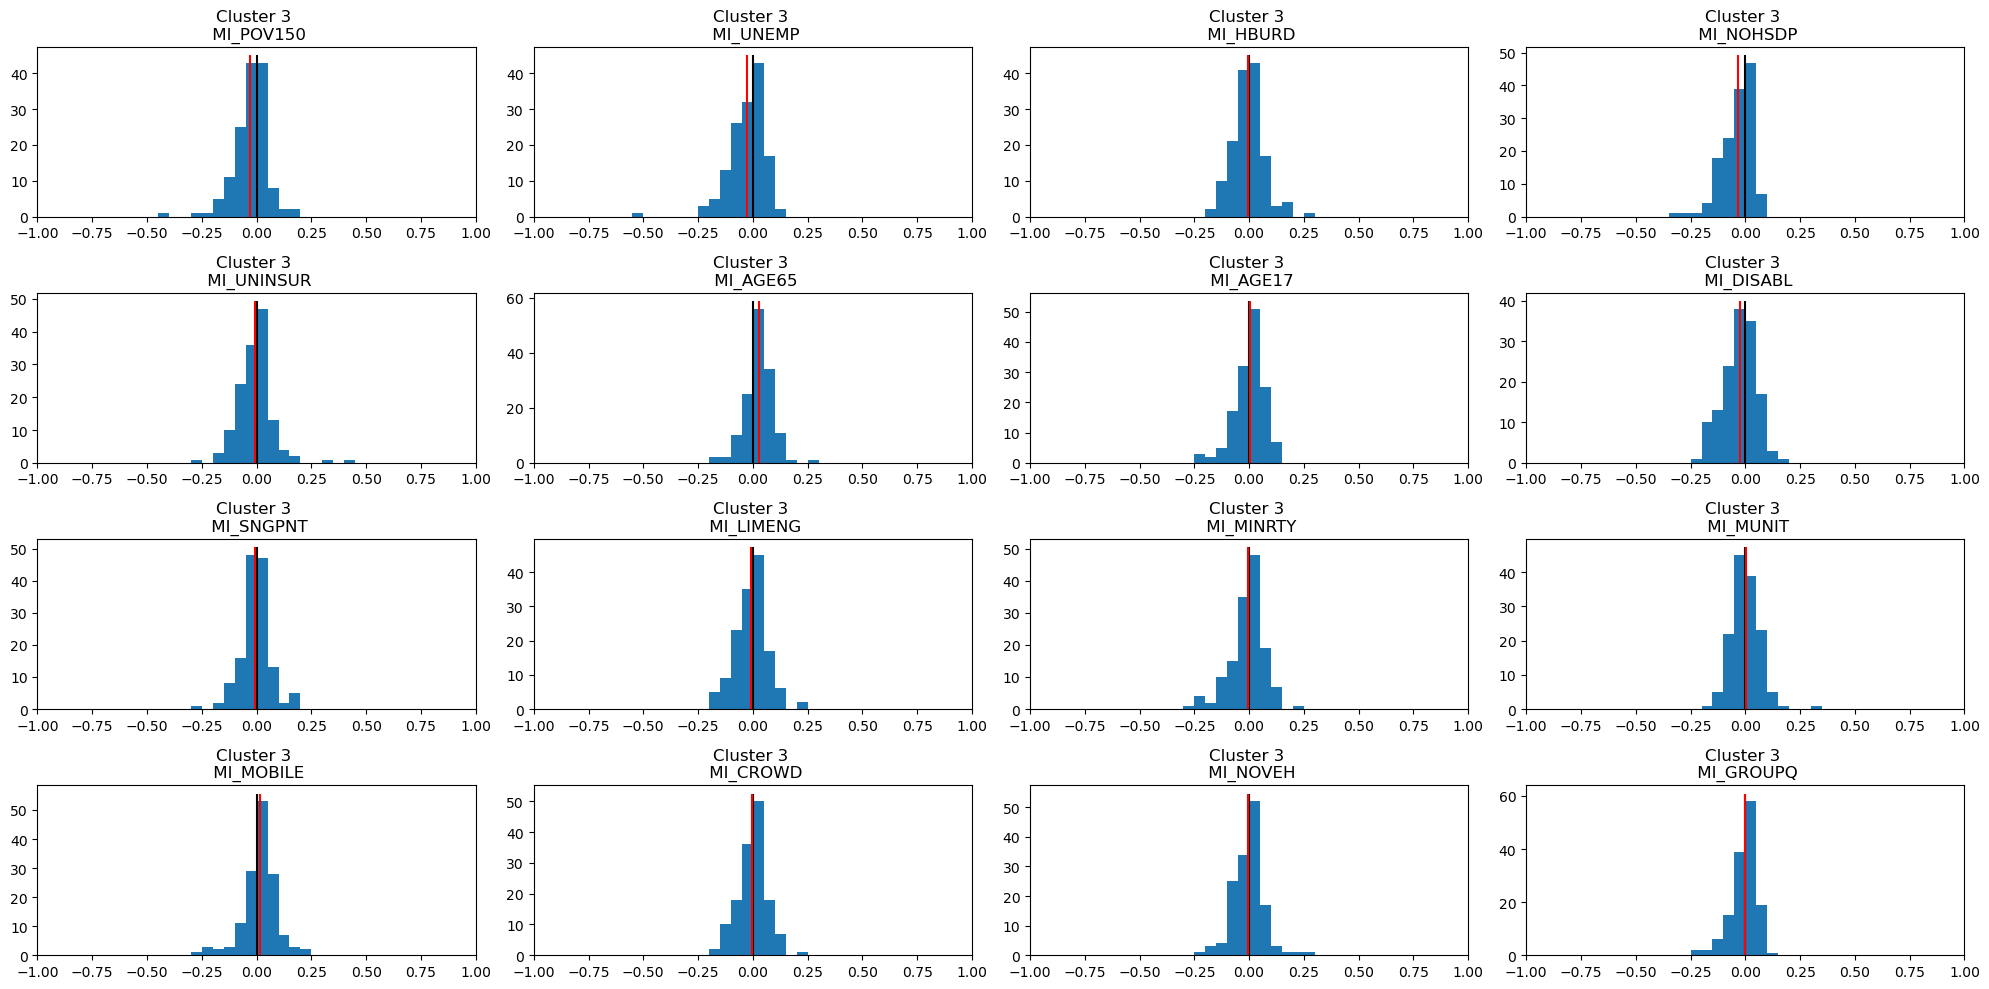

In [47]:
binwidth = 0.05
n = 10
for c in range(4):
    fig, axes = plt.subplots(4, 4, figsize=(20, 10))
    axes = axes.reshape(-1)
    for col_idx, col in enumerate([col for col in mi_.columns if col.startswith('MI')]):
        temp_cluster_ = mi_.loc[mi_['cluster'] == c, [col]].values
        bins = np.arange(math.floor(min(temp_cluster_) * n) / n, math.ceil(max(temp_cluster_) * n) / n + binwidth, binwidth)
        axes[col_idx].hist(temp_cluster_, bins=bins)
        axes[col_idx].set_xlim(-1, 1)
        
        ylim = axes[col_idx].get_ylim()[1]
        axes[col_idx].vlines(0, 0, ylim, color='black')
        axes[col_idx].vlines(temp_cluster_.mean(), 0, ylim, color='red')
        axes[col_idx].set_title(f"Cluster {c} \n {col}")
    plt.tight_layout()


3 142
2 49
1 82
0 72


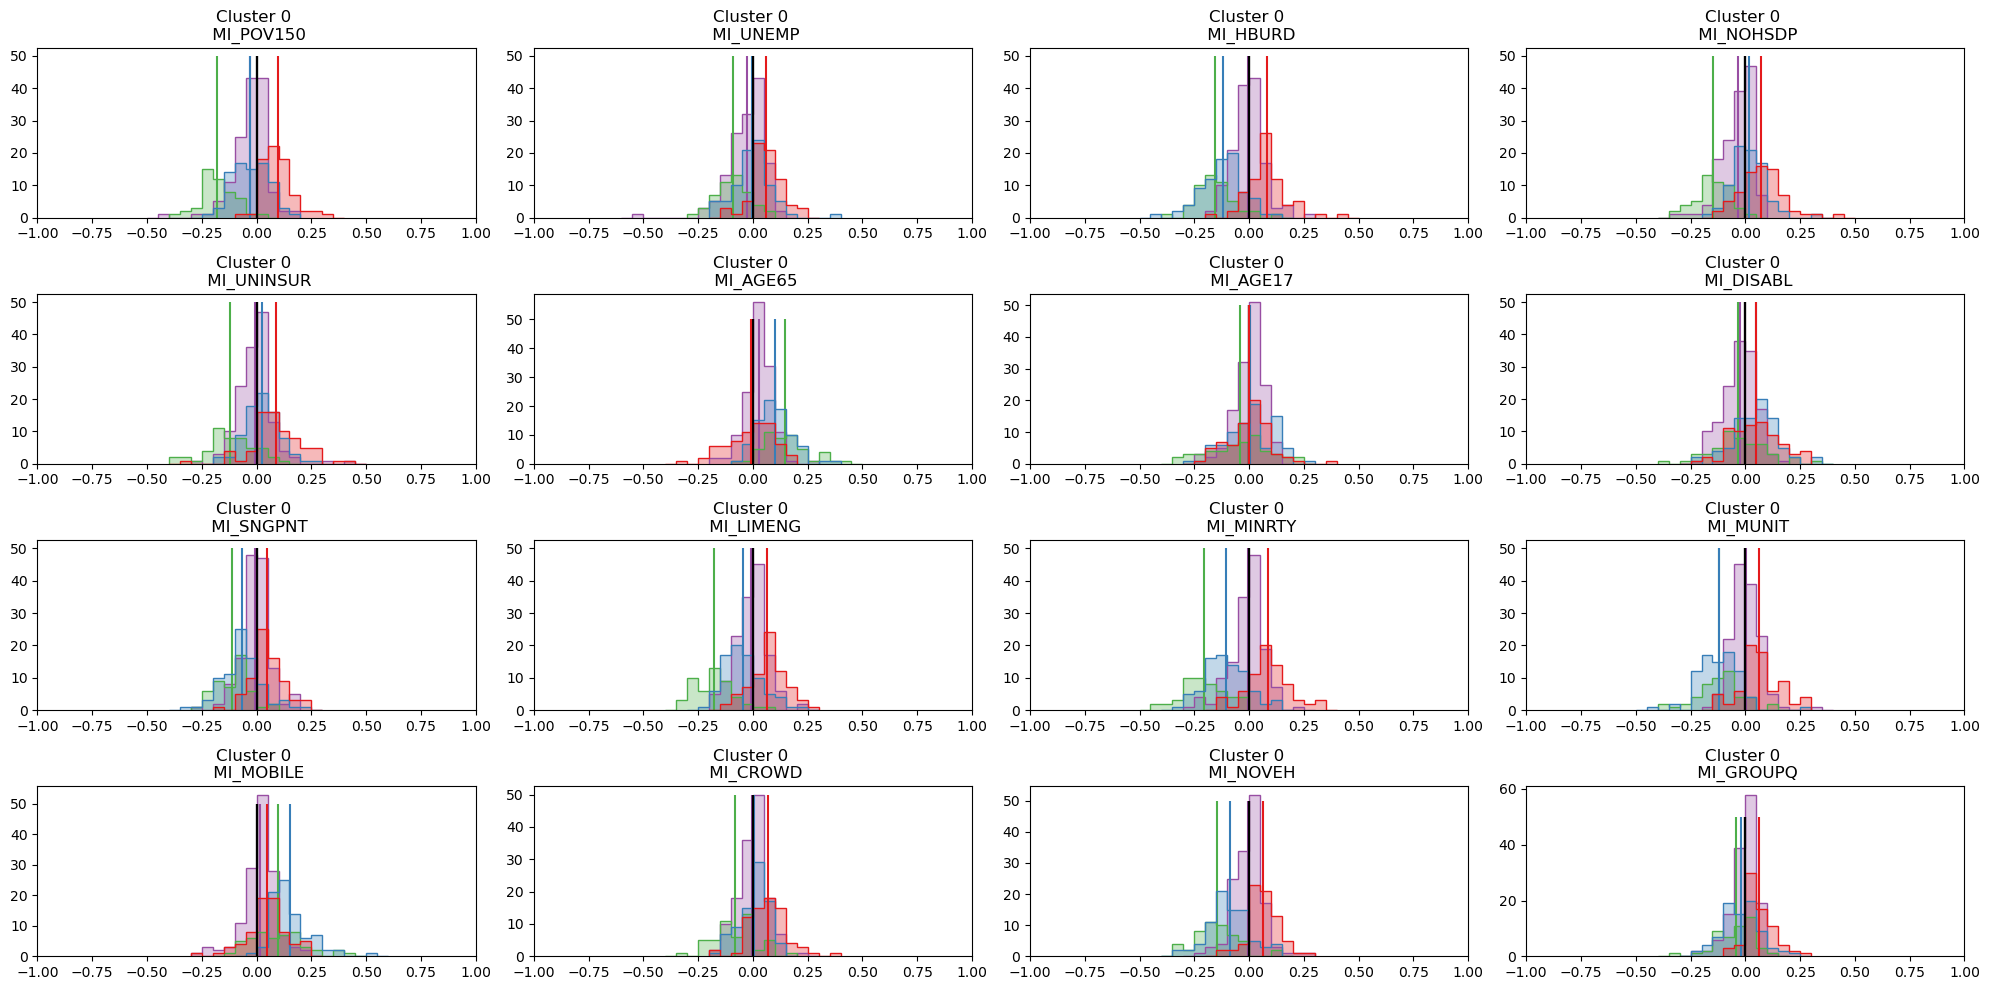

In [68]:
binwidth = 0.05
n = 10
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']

fig, axes = plt.subplots(4, 4, figsize=(20, 10))
axes = axes.reshape(-1)

for c in range(3, -1, -1): 
    for col_idx, col in enumerate([col for col in mi_.columns if col.startswith('MI')]):
        temp_cluster_ = mi_.loc[mi_['cluster'] == c, [col]].values
        bins = np.arange(math.floor(min(temp_cluster_) * n) / n, math.ceil(max(temp_cluster_) * n) / n + binwidth, binwidth)
        axes[col_idx].hist(temp_cluster_, bins=bins, color=colors[c], histtype='stepfilled', alpha=0.3)
        axes[col_idx].hist(temp_cluster_, bins=bins, color=colors[c], histtype='step')
        axes[col_idx].set_xlim(-1, 1)
        
        ylim = axes[col_idx].get_ylim()[1]
        axes[col_idx].vlines(0, 0, 50, color='black')
        axes[col_idx].vlines(temp_cluster_.mean(), 0, 50, color=colors[c])
        axes[col_idx].set_title(f"Cluster {c} \n {col}")
    print(c, temp_cluster_.shape[0])
    plt.tight_layout()


In [155]:
mi_ = mi[['MI_AGE65',
 'MI_AGE17',
 'MI_DISABL',
 'MI_SNGPNT',
 'MI_LIMENG']]
km_cost = []  # Sum of squared distances of samples to their closest cluster center.
distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
km_silhouette = {}

for i in range(2, 15):
    KM = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)
    KM.fit(mi_)

    # Calculate Silhouette Scores
    preds = KM.predict(mi_)
    silhouette = silhouette_score(mi_, preds)
    km_silhouette[i] = silhouette
    print(silhouette)


0.23678977331711956
0.16055128373676053
0.1586698996432504
0.15608183571913567
0.16138471150435288
0.16749888193706278
0.1651932110906345
0.1560606055351768
0.16136000524961364
0.15440473643962258
0.1582984460912639
0.15784838853813918
0.16397252052978584


In [157]:
# mi_ = mi[['MI_AGE65',
#  'MI_AGE17',
#  'MI_DISABL',
#  'MI_SNGPNT',
#  'MI_LIMENG']]

temp_ = kmeans_cluster(mi_, 2)
mi_['cluster'] = temp_
cluster_mi = mi_.copy(deep=True)
cluster_mi

/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_97827/1127505593.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_['cluster'] = temp_


MI_AGE65  MI_AGE17  MI_DISABL  MI_SNGPNT  MI_LIMENG  cluster
0    0.033353  0.010902   0.064272   0.025284  -0.121798        0
1    0.126686 -0.128580  -0.005098   0.046259   0.112956        1
2    0.180915  0.032000  -0.219862  -0.183137  -0.183676        0
3   -0.155445  0.123823   0.058082   0.239993   0.158026        1
4   -0.191313  0.051426  -0.022916  -0.026695   0.053645        1
..        ...       ...        ...        ...        ...      ...
340  0.095964 -0.129570   0.053559   0.025072   0.088068        1
341  0.080616  0.073809  -0.100923   0.054950   0.029311        1
342  0.419107 -0.065566   0.248452  -0.191892  -0.279891        0
343 -0.069844  0.051737  -0.198194   0.074114  -0.031001        1
344 -0.074578  0.225513   0.162344   0.247114  -0.040253        1

[345 rows x 6 columns]

136.0
209.0


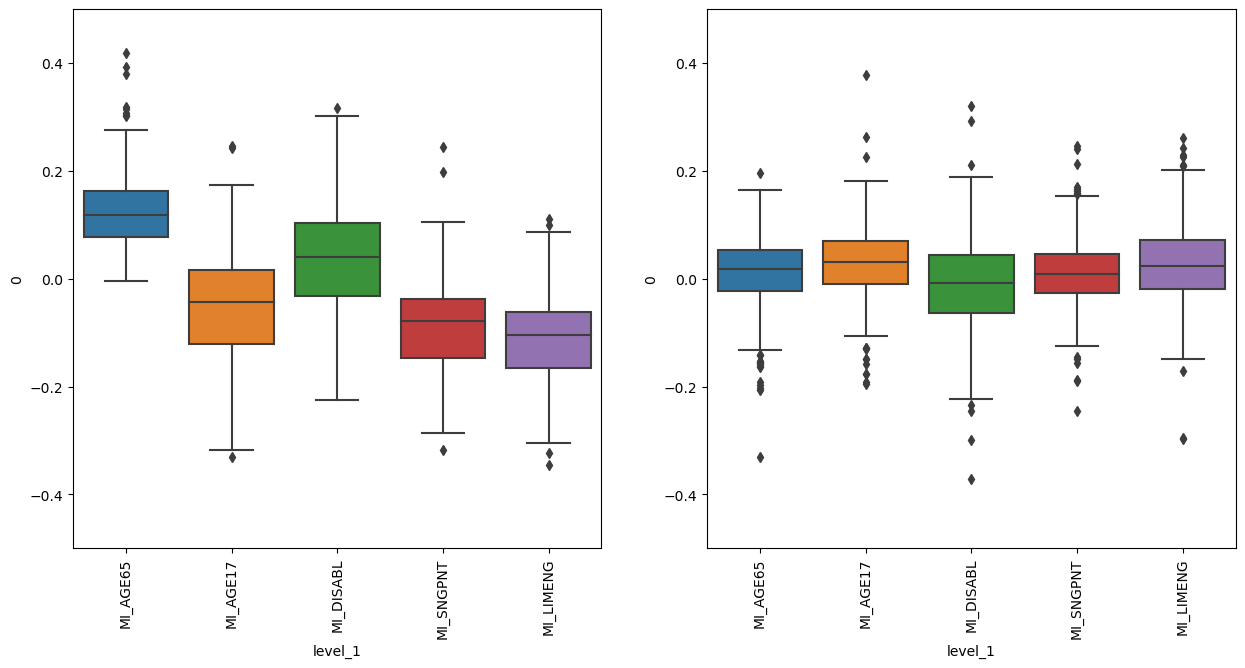

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
        
for c in range(2):
    temp_cluster = mi_.loc[cluster_mi['cluster'] == c, [col for col in mi_.columns if col.startswith('MI')]].stack().reset_index()
    print(temp_cluster.shape[0]/5)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
    ax[c].set_ylim(-0.5, 0.5)
    ax[c].set_xticklabels([col for col in mi_.columns if col.startswith('MI')], rotation = 'vertical')

MI_AGE65  MI_AGE17  MI_DISABL  MI_SNGPNT  MI_LIMENG  cluster
8   -0.329967  0.378067  -0.223108   0.118123   0.261688        1
70  -0.206526  0.034954  -0.022291   0.090041   0.102666        1
221 -0.202018  0.005704  -0.008242  -0.020360   0.108186        1
18  -0.198021  0.176280   0.148488   0.212359   0.163842        1
4   -0.191313  0.051426  -0.022916  -0.026695   0.053645        1

In [146]:
cluster_mi.nsmallest(3, 'MI_NOHSDP')

MI_POV150  MI_UNEMP  MI_HBURD  MI_NOHSDP  MI_UNINSUR  cluster
261  -0.192496 -0.196979  0.172168  -0.325686    0.303150        1
120  -0.083065  0.025187 -0.052974  -0.316920   -0.301196        1
182  -0.205638 -0.250468  0.013570  -0.301299   -0.364875        1

In [145]:
cluster_mi.loc[cluster_mi['cluster'] == 0, ['MI_NOHSDP']].nsmallest(5).values

TypeError: nsmallest() missing 1 required positional argument: 'columns'

In [142]:
cluster_mi.loc[cluster_mi['MI_NOHSDP'] == cluster_mi.loc[cluster_mi['cluster'] == 0, ['MI_NOHSDP']].min().values[0]]

MI_POV150  MI_UNEMP  MI_HBURD  MI_NOHSDP  MI_UNINSUR  cluster
39   0.049741  0.145249  0.046755  -0.124129    0.156232        0

In [136]:
mi['MI_NOHSDP'].min()

-0.3256864152224203

## Plot distribution of variables per region

EastSouthCentral 34


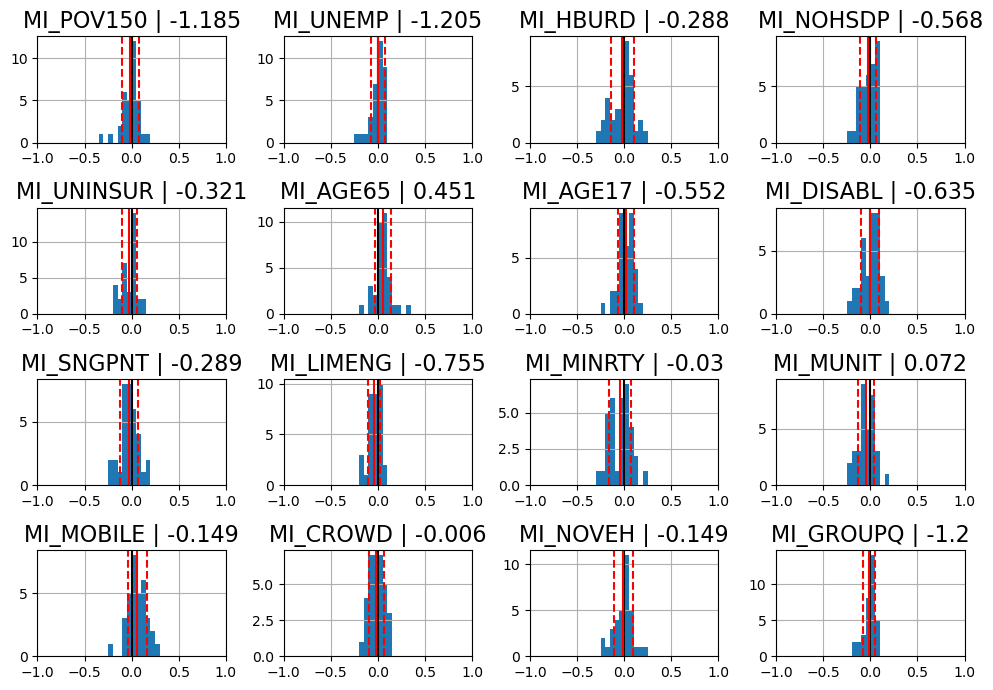

Pacific 39


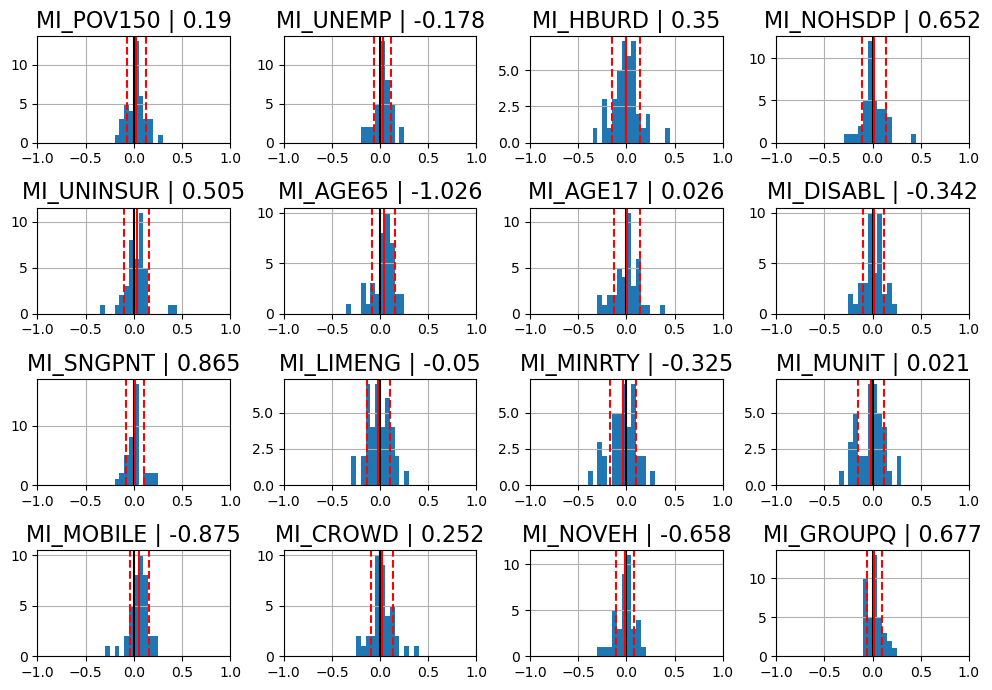

Mountain 18


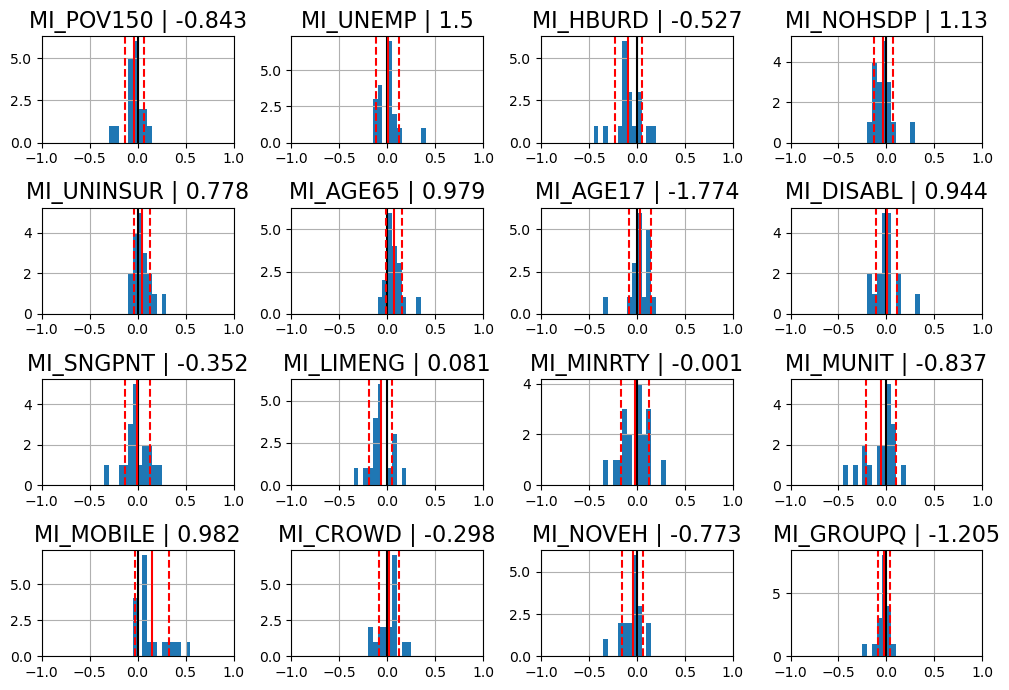

WestSouthCentral 63


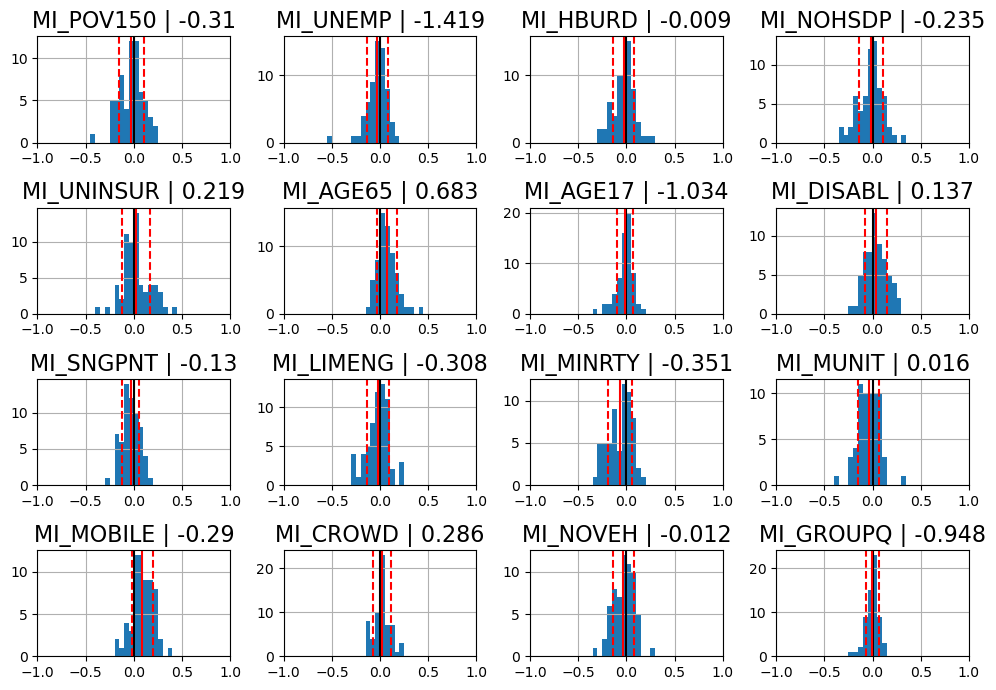

NewEngland 28


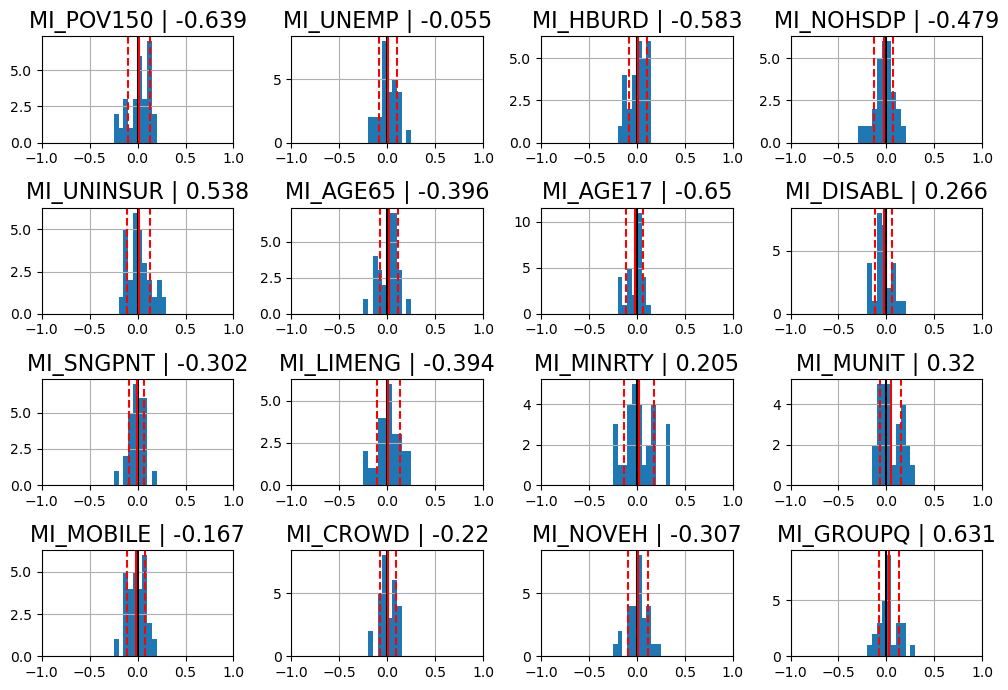

SouthAtlantic 31


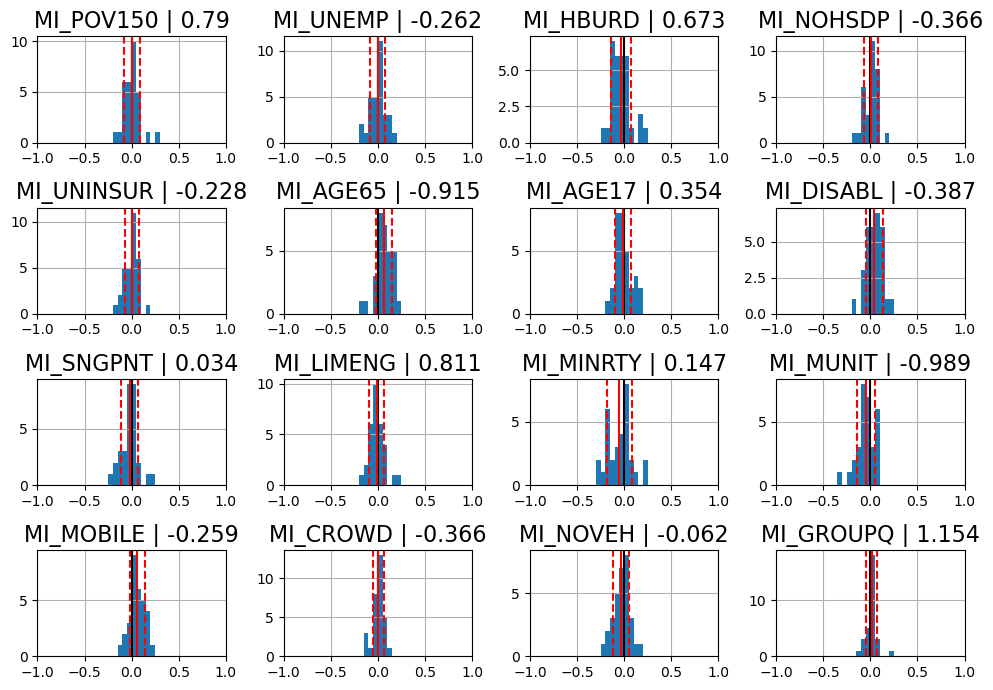

EastNorthCentral 43


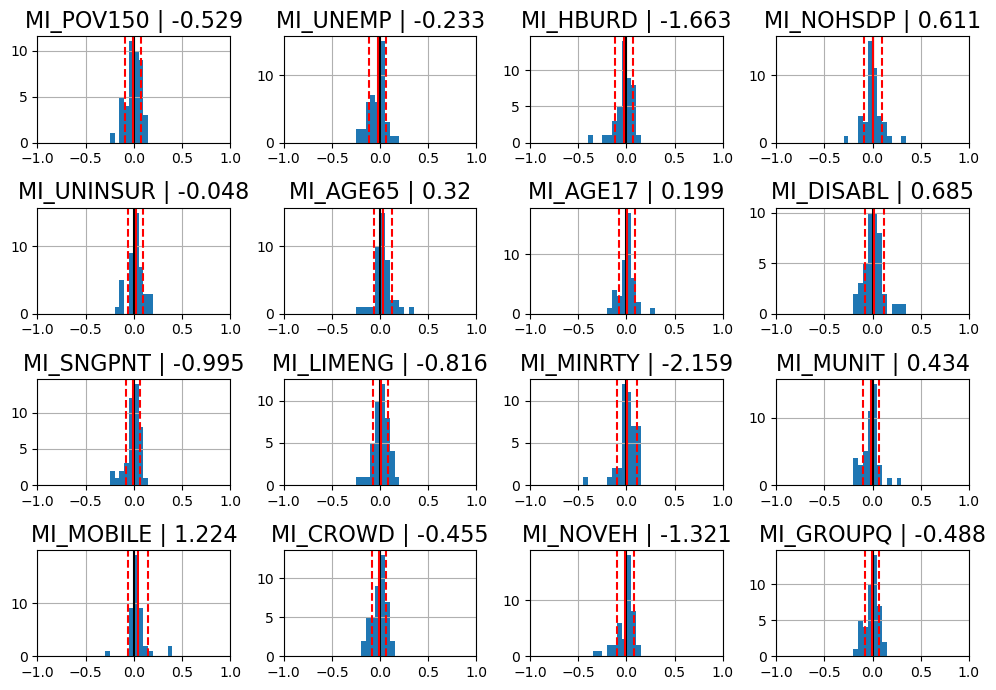

WestNorthCentral 64


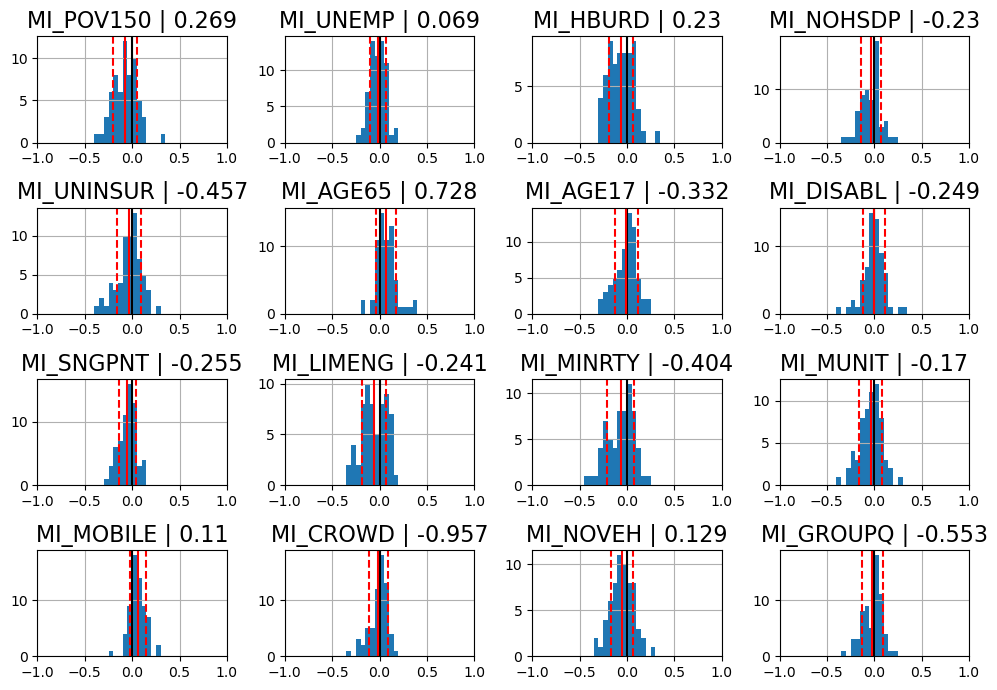

MiddleAtlantic 25


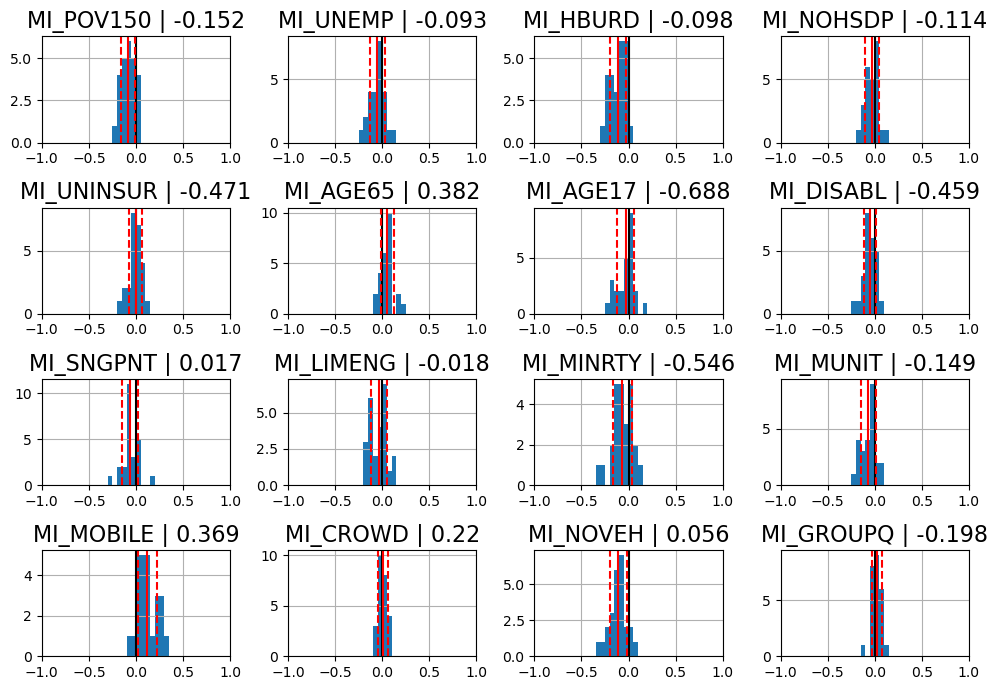

In [103]:
for region in state_lookup['Region'].unique():

    if type(region) == str:
        mi_ = mi.loc[mi['Region'] == region, [col for col in mi.columns if col.startswith('MI')]]
        print(region, mi_.shape[0])
        
        fig, axes = plt.subplots(4, 4, figsize=(10,7))
        ax = axes.reshape(-1)

        binwidth = 0.05
        n = 10
        for idx, col in enumerate(plot_cols_mi):
            bins = np.arange(math.floor(min(mi_[col]) * n) / n, math.ceil(max(mi_[col]) * n) / n + binwidth, binwidth)
            mi_[col].hist(ax=ax[idx], bins=bins)
            
#             mi_[col].hist(ax=ax[idx], bins=np.arange(min(mi_[col]), max(mi_[col]) + binwidth, binwidth))
            ylim = ax[idx].get_ylim()[1]
            ax[idx].vlines(0, 0, ylim, color='black')
            ax[idx].vlines(mi_[col].mean(), 0, ylim, color='red')
            ax[idx].vlines(mi_[col].mean() - mi_[col].std(), 0, ylim, color='red', linestyle='dashed')
            ax[idx].vlines(mi_[col].mean() + mi_[col].std(), 0, ylim, color='red', linestyle='dashed')
            skew_val = scipy.stats.skew(mi_[col])
            ax[idx].set_title(label=f"{col} | {round(skew_val, 3)}", fontsize=16)
#             ax[idx].set_title(label=f"{col}", fontsize=16)
            ax[idx].set_xlim(-1, 1)
            ax[idx].set_ylim(0, ylim)

        plt.tight_layout()
        plt.show()


## Overall K-Means

In [120]:
def determine_number_of_cluster(array):
    km_cost = []  # Sum of squared distances of samples to their closest cluster center.
    distortions = []  # the average of the squared distances from the cluster centers of the respective clusters.Typically, the Euclidean distance metric is used.
    km_silhouette = {}

    for i in range(2, 11):
        KM = KMeans(n_clusters=i, max_iter=999, n_init = 99, random_state=17)
        KM.fit(array)

        # Calculate Silhouette Scores
        preds = KM.predict(array)
        silhouette = silhouette_score(array, preds)
        km_silhouette[i] = silhouette

#     print(max(km_silhouette, key=km_silhouette.get))
#     print(km_silhouette)
        
    return km_silhouette

def kmeans_cluster(array, num_of_cluster):
    kmeans = KMeans(n_clusters=num_of_cluster, max_iter=999, n_init = 99, random_state=17)
    kmeans.fit(array)
    y_kmeans = kmeans.predict(array)
    
    cluster_df = pd.DataFrame({'cluster': y_kmeans}, index=array.index)
    
    return cluster_df

In [51]:
determine_number_of_cluster(mi_)

{2: 0.21319386059875747,
 3: 0.13561488995378165,
 4: 0.12501338708181164,
 5: 0.1325210663670404,
 6: 0.12333435742409508,
 7: 0.08949921965025646,
 8: 0.08697932897693245,
 9: 0.07206618094674644,
 10: 0.08110718787935485}

206.0
139.0


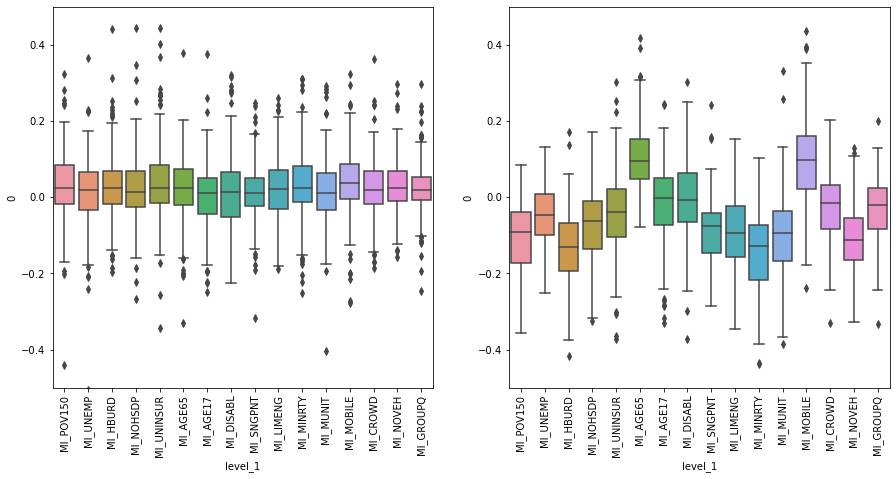

In [52]:
opt_cluster = 2

mi_ = mi[[col for col in mi.columns if col.startswith('MI')]]

cluster_mi = kmeans_cluster(mi_, opt_cluster)
cluster_mi

fig, ax = plt.subplots(1, opt_cluster, figsize=(15, 7))
        
for c in range(opt_cluster):
    temp_cluster = mi_.loc[cluster_mi['cluster'] == c].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
    ax[c].set_ylim(-0.5, 0.5)
    ax[c].set_xticklabels([col for col in mi.columns if col.startswith('MI')], rotation = 'vertical')

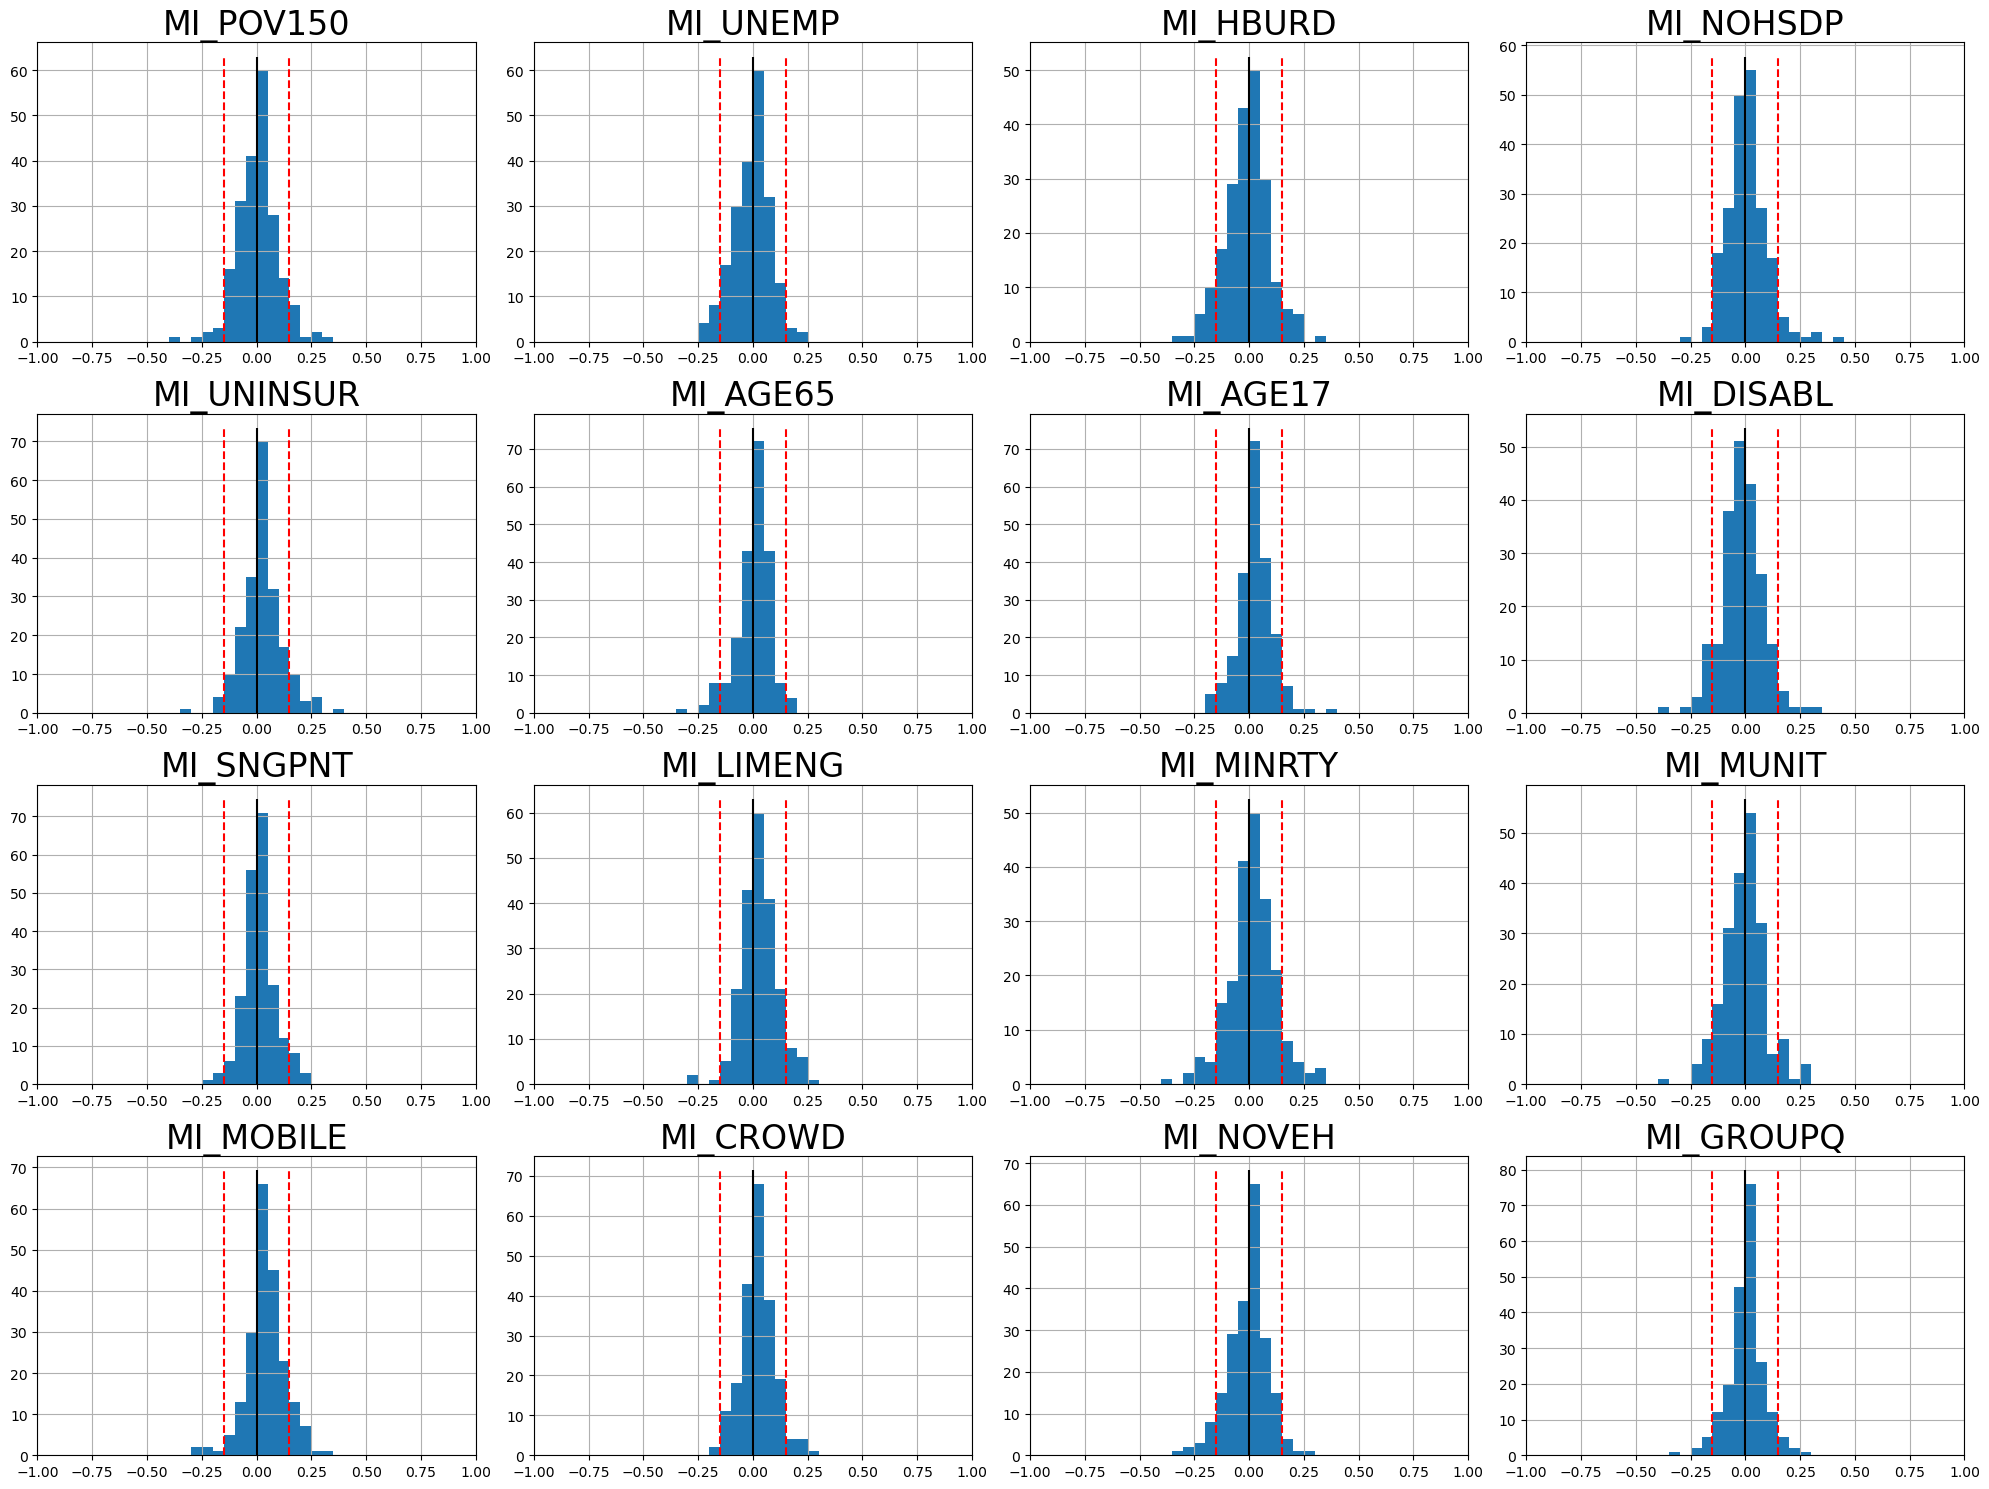

In [160]:
mi_ = mi.loc[mi.index.isin(cluster_mi.loc[cluster_mi['cluster'] == 1].index), [col for col in mi.columns if col.startswith('MI')]]

for col in mi_.columns:
    mi_ = mi_.loc[pd.notna(mi_[col])]
    
mi_

fig, axes = plt.subplots(4, 4, figsize=(20,15))
ax = axes.reshape(-1)

binwidth = 0.05
n = 10
for idx, col in enumerate(plot_cols_mi):
    bins = np.arange(math.floor(min(mi_[col]) * n) / n, math.ceil(max(mi_[col]) * n) / n + binwidth, binwidth)
    mi_[col].hist(ax=ax[idx], bins=bins)
    
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
#     ax[idx].vlines(mi_[col].mean(), 0, ylim, color='red')
    ax[idx].vlines(-0.15, 0, ylim, color='red', linestyle='dashed')
    ax[idx].vlines(0.15, 0, ylim, color='red', linestyle='dashed')
    
    ax[idx].set_title(label=f"{col}", fontsize=24)
    ax[idx].set_xlim(-1, 1)
    
plt.tight_layout()
plt.show()
    

In [53]:
cluster_mi

cluster
0          0
1          0
2          1
3          0
4          0
..       ...
340        0
341        0
342        1
343        0
344        0

[345 rows x 1 columns]

In [36]:

mi_

MI_POV150  MI_UNEMP  MI_HBURD  MI_NOHSDP  MI_UNINSUR  MI_AGE65  MI_AGE17  \
0     0.015705 -0.017574  0.083044  -0.059295   -0.078009  0.033353  0.010902   
1     0.197722  0.226742  0.228896  -0.028454   -0.085629  0.126686 -0.128580   
2    -0.169999 -0.160956 -0.196013  -0.180554    0.027277  0.180915  0.032000   
3     0.181810  0.082801  0.180473   0.168056    0.105109 -0.155445  0.123823   
4     0.025983  0.034825 -0.062186   0.162110    0.112381 -0.191313  0.051426   
..         ...       ...       ...        ...         ...       ...       ...   
340   0.083641  0.013976  0.054407   0.031443   -0.077466  0.095964 -0.129570   
341  -0.073615 -0.053885 -0.087424  -0.045171    0.076487  0.080616  0.073809   
342  -0.181453 -0.087180 -0.206407  -0.220547   -0.141647  0.419107 -0.065566   
343   0.033715  0.057711  0.041060  -0.122407    0.008481 -0.069844  0.051737   
344   0.048514 -0.100838  0.212380   0.032367   -0.342003 -0.074578  0.225513   

     MI_DISABL  MI_SNGPNT  MI_LIMENG  MI_MINRTY  MI_MUNIT  MI_MOBILE  \
0     0.064272   0.025284  -0.121798  -0.009425  0.103823  -0.061876   
1    -0.005098   0.046259   0.112956   0.014687  0.138694   0.067236   
2    -0.219862  -0.183137  -0.183676  -0.261286 -0.216439   0.292983   
3     0.058082   0.239993   0.158026   0.281753  0.164588  -0.162967   
4    -0.022916  -0.026695   0.053645   0.083342 -0.142796   0.048700   
..         ...        ...        ...        ...       ...        ...   
340   0.053559   0.025072   0.088068  -0.048193  0.002125   0.036644   
341  -0.100923   0.054950   0.029311   0.026226 -0.034311   0.044175   
342   0.248452  -0.191892  -0.279891  -0.265601 -0.208911   0.353174   
343  -0.198194   0.074114  -0.031001   0.058621  0.002109  -0.025687   
344   0.162344   0.247114  -0.040253   0.170155  0.276367  -0.271757   

     MI_CROWD  MI_NOVEH  MI_GROUPQ  
0    0.017522  0.098574   0.004487  
1   -0.018645  0.076771   0.046384  
2   -0.054337 -0.266608   0.130085  
3    0.142658  0.112878   0.020701  
4    0.155419 -0.009343   0.238868  
..        ...       ...        ...  
340  0.060479  0.028443   0.124544  
341  0.016625 -0.062923  -0.063345  
342 -0.020082 -0.167463  -0.149443  
343 -0.079626  0.052645  -0.000441  
344  0.252073 -0.118120   0.058367  

[345 rows x 16 columns]

In [64]:
for i in range(2, 11):
    clusters = AgglomerativeClustering(n_clusters=i, linkage='ward').fit(mi_)
    silhouette = silhouette_score(mi_, clusters.labels_)
    print(silhouette)

0.2000621238663444
0.17036346359330667
0.1518041857217432
0.15020716207330054
0.13623538558693957
0.14052900150821035
0.15347437018232074
0.13431830351171226
0.14089428293331


In [60]:
[col for col in mi.columns if col.startswith('MI_')]

['MI_POV150',
 'MI_UNEMP',
 'MI_HBURD',
 'MI_NOHSDP',
 'MI_UNINSUR',
 'MI_AGE65',
 'MI_AGE17',
 'MI_DISABL',
 'MI_SNGPNT',
 'MI_LIMENG',
 'MI_MINRTY',
 'MI_MUNIT',
 'MI_MOBILE',
 'MI_CROWD',
 'MI_NOVEH',
 'MI_GROUPQ']

0.2000621238663444
0
213.0
1
132.0


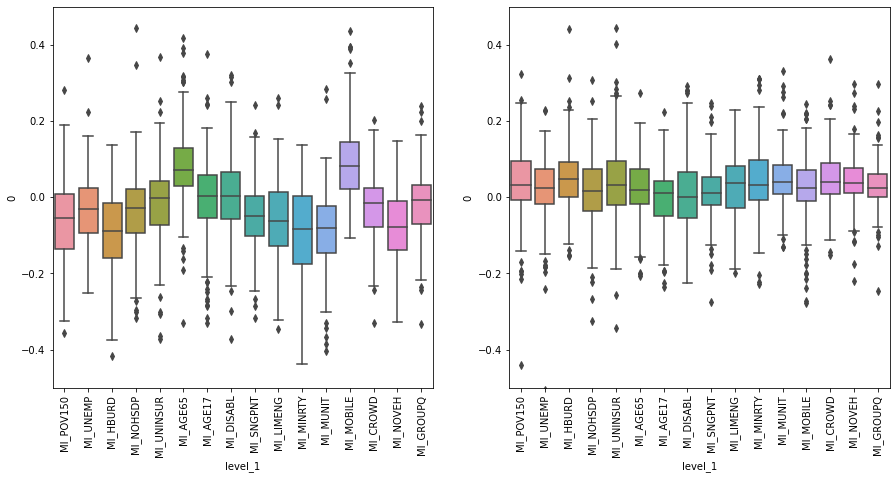

In [63]:
mi_ = mi[['MI_MUNIT',
 'MI_MOBILE',
 'MI_CROWD',
 'MI_NOVEH',
 'MI_GROUPQ']]

clusters = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(mi_)
silhouette = silhouette_score(mi_, clusters.labels_)
print(silhouette)
mi['cluster'] = clusters.labels_
clusters.labels_

opt_cluster = max(clusters.labels_) + 1

fig, ax = plt.subplots(1, opt_cluster, figsize=(15, 7))

for c in range(opt_cluster):
    print(c)
    temp_cluster = mi.loc[mi['cluster'] == c, [col for col in mi.columns if col.startswith('MI_')]].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
    ax[c].set_ylim(-0.5, 0.5)
    ax[c].set_xticklabels([col for col in mi.columns if col.startswith('MI')], rotation = 'vertical')

0
89.0
1
70.0
2
52.0
3
122.0
4
12.0


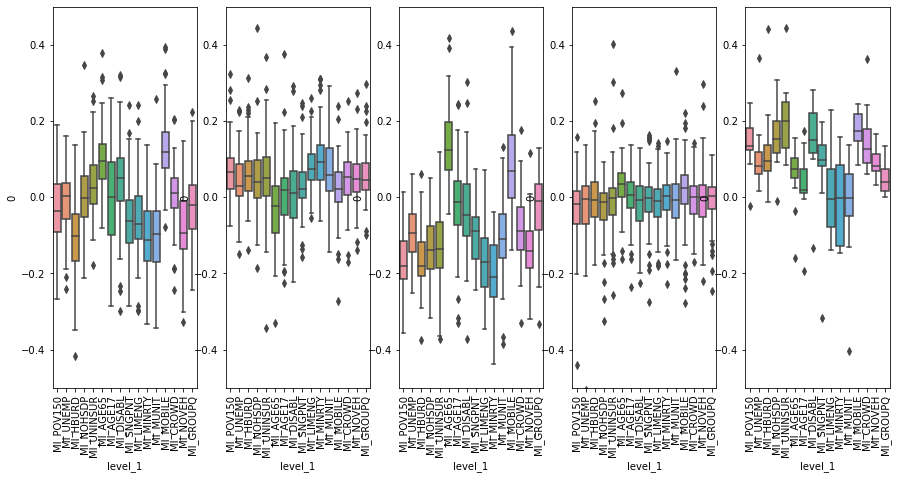

In [48]:
clusters = AgglomerativeClustering(n_clusters=5, linkage='ward').fit(mi_)
mi['cluster'] = clusters.labels_
clusters.labels_

opt_cluster = max(clusters.labels_) + 1

fig, ax = plt.subplots(1, opt_cluster, figsize=(15, 7))

for c in range(opt_cluster):
    print(c)
    temp_cluster = mi.loc[mi['cluster'] == c, [col for col in mi.columns if col.startswith('MI_')]].stack().reset_index()
    print(temp_cluster.shape[0]/16)
    sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
    ax[c].set_ylim(-0.5, 0.5)
    ax[c].set_xticklabels([col for col in mi.columns if col.startswith('MI')], rotation = 'vertical')

In [13]:
len(clusters.labels_)

345

In [95]:
# Detailed plot of every sequence detected in dynamic spatial accessibility either on weekdays or weekends

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

cut_bins = [-np.inf,-0.15, -0.05, 0.05, 0.15, np.inf]
score_labels = [1, 2, 3, 4, 5]
mi['COD_POV150']= pd.cut(mi['MI_POV150'], 
                            bins=cut_bins, 
                            labels=score_labels)
mi['COD_UNEMP']= pd.cut(mi['MI_UNEMP'], 
                            bins=cut_bins, 
                            labels=score_labels)
mi

color_brewer = ['#d7191c','#fdae61','#ffffbf','#abd9e9','#2c7bb6']
color_brewer.reverse()
color_map = {idx: np.array(hex_to_rgb(value)) for idx, value in enumerate(color_brewer, 1)}

In [106]:
# make a 3d numpy array that has a color channel dimension   
data = mi[['COD_POV150', 'COD_UNEMP']].to_numpy()
data_3d = np.ndarray(shape=(data.shape[0], data.shape[1], 3), dtype=int)
for x in range(0, data.shape[0]):
    for y in range(0, data.shape[1]):
        data_3d[x][y] = color_map[data[x][y]]

In [104]:
mi[['COD_POV150', 'COD_UNEMP']].sort_values(by='COD_POV150', inplace=True)

/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_80932/2352967333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi[['COD_POV150', 'COD_UNEMP']].sort_values(by='COD_POV150', inplace=True)


In [108]:
data_3d

array([[[255, 255, 191],
        [255, 255, 191]],

       [[215,  25,  28],
        [215,  25,  28]],

       [[ 44, 123, 182],
        [ 44, 123, 182]],

       ...,

       [[ 44, 123, 182],
        [171, 217, 233]],

       [[255, 255, 191],
        [253, 174,  97]],

       [[255, 255, 191],
        [171, 217, 233]]])

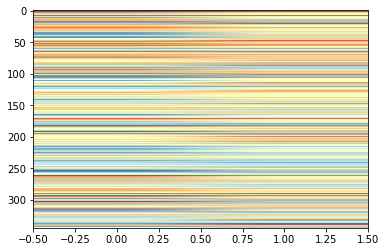

In [107]:
plt.imshow(data_3d, aspect ='auto')

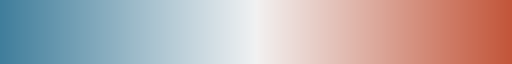

In [86]:
cmap

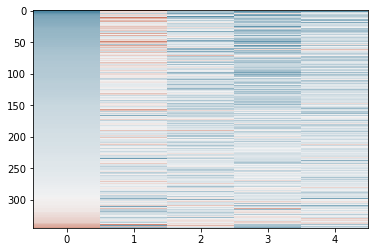

In [80]:
plt.imshow(mi_, interpolation='none', aspect ='auto', cmap=cmap)

In [84]:
mi[[col for col in mi.columns if col.startswith('MI_')]].min()

MI_POV150    -0.440132
MI_UNEMP     -0.505338
MI_HBURD     -0.417570
MI_NOHSDP    -0.325686
MI_UNINSUR   -0.373406
MI_AGE65     -0.329967
MI_AGE17     -0.331370
MI_DISABL    -0.371821
MI_SNGPNT    -0.317716
MI_LIMENG    -0.345945
MI_MINRTY    -0.438004
MI_MUNIT     -0.402696
MI_MOBILE    -0.278690
MI_CROWD     -0.330414
MI_NOVEH     -0.326273
MI_GROUPQ    -0.333458
dtype: float64

In [85]:
mi[[col for col in mi.columns if col.startswith('MI_')]].max()

MI_POV150     0.324735
MI_UNEMP      0.365222
MI_HBURD      0.443038
MI_NOHSDP     0.445262
MI_UNINSUR    0.444801
MI_AGE65      0.419107
MI_AGE17      0.378067
MI_DISABL     0.321280
MI_SNGPNT     0.247114
MI_LIMENG     0.261688
MI_MINRTY     0.312157
MI_MUNIT      0.331034
MI_MOBILE     0.546438
MI_CROWD      0.364841
MI_NOVEH      0.299246
MI_GROUPQ     0.298133
dtype: float64

In [82]:
mi_

MI_MUNIT  MI_MOBILE  MI_CROWD  MI_NOVEH  MI_GROUPQ
200 -0.402696   0.546438  0.067533  0.110531   0.009972
182 -0.385607   0.197111  0.177832 -0.308833  -0.069344
105 -0.366768   0.136632 -0.118120 -0.319950  -0.333458
283 -0.344498   0.143896 -0.116815 -0.216561  -0.026581
141 -0.331388   0.390702  0.067428 -0.326273  -0.005968
..        ...        ...       ...       ...        ...
53   0.264633   0.103293  0.147093  0.041534   0.298133
344  0.276367  -0.271757  0.252073 -0.118120   0.058367
8    0.286135   0.239587  0.108163 -0.139374  -0.088880
171  0.292050  -0.085594  0.032401  0.273441   0.100311
261  0.331034  -0.176612 -0.034247 -0.219651  -0.018968

[345 rows x 5 columns]

In [72]:
mi_.sort_values(by='MI_MUNIT', inplace=True)

/var/folders/dv/bcrkszqj0634wz_17m9xw0qr0000gn/T/ipykernel_80932/1746517212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_.sort_values(by='MI_MUNIT', inplace=True)


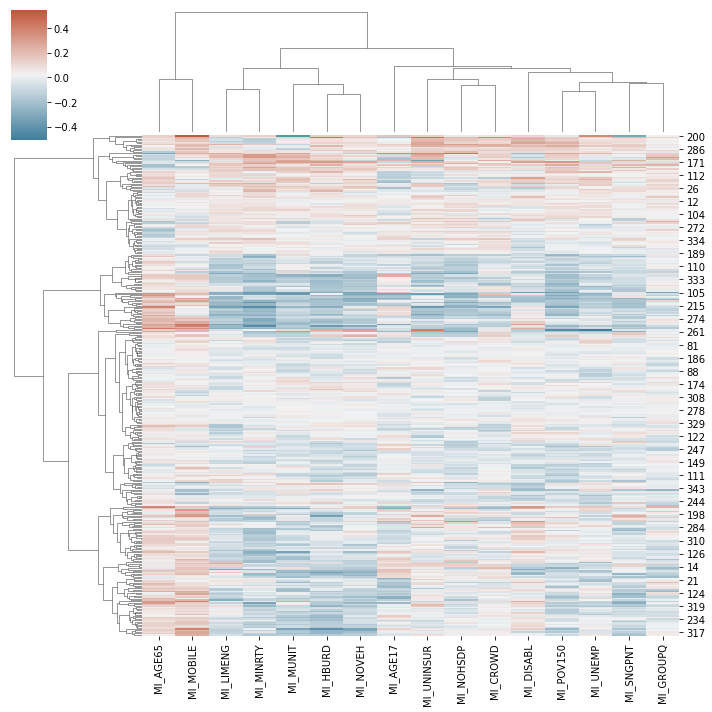

In [78]:
mi_ = mi[[col for col in mi.columns if col.startswith('MI_')]]
mi_
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.clustermap(mi_, method='ward', cmap=cmap)

In [ ]:
# for region in state_lookup['Region'].unique():

#     if type(region) == str:
#         print(region)
#         mi_ = mi.loc[mi['Region'] == region, [col for col in mi.columns if col.startswith('MI')]]
#         sil_coef = determine_number_of_cluster(mi_)
#         print(f"{region} | optimal cluster count: {max(sil_coef, key=sil_coef.get)}")
        
# #         opt_cluster = max(sil_coef, key=sil_coef.get)
        
#         cluster_mi = kmeans_cluster(mi_, 3)
        
#         fig, ax = plt.subplots(1, opt_cluster, figsize=(15, 7))
        
#         for c in range(opt_cluster):
#             temp_cluster = mi_.loc[cluster_mi['cluster'] == c].stack().reset_index()
#             print(c, temp_cluster.shape[0]/16)
#             sns.boxplot(x = 'level_1', y = 0, data=temp_cluster, ax=ax[c])
#             ax[c].set_ylim(-0.5, 0.5)
#             ax[c].set_xticklabels([col for col in mi.columns if col.startswith('MI')], rotation = 'vertical')

#         plt.tight_layout()
#         plt.show()

## Geographical locations 

In [45]:
state = gpd.read_file('./census_geometry/tl_2022_us_state.shp')
state = state.merge(state_lookup, left_on='STUSPS', right_on='Abbr')
state = state.loc[state['ContiguousUS'] == 1]
state = state.to_crs(epsg=5070)

In [46]:
cols = [col.split('_')[1] for col in census_info.keys()]
cols

for idx, row in mi.iterrows():
    for col in cols:
        if (row[f"pval_{col}"] < 0.05) & (row[f"MI_{col}"] >= 0.15):
            mi.at[idx, f'Code_{col}'] = 'PO_C' # Positive correlation
        elif (row[f"pval_{col}"] < 0.05) & (row[f"MI_{col}"] <= -0.15):
            mi.at[idx, f'Code_{col}'] = 'NE_C' # Negative correlation
        else:
            mi.at[idx, f'Code_{col}'] = 'NO_C' # No correlation




# Count code (PO, NE, NO) per dam 
for idx, row in mi.iterrows():
    mi.at[idx, 'Count_NE'] = sum(row == 'NE_C')
    mi.at[idx, 'Count_PO'] = sum(row == 'PO_C')
    mi.at[idx, 'Count_NO'] = sum(row == 'NO_C')

mi = mi.to_crs(epsg=5070)
mi


ID        LAT         LON                    NAME  LIBRARY_ID  \
0    CA10114  36.416309 -119.003224            TERMINUS DAM         199   
1    CA10113  36.060671 -118.919340  Richard L. Schafer Dam          98   
2    NY00468  42.733294  -77.907232        MOUNT MORRIS DAM         316   
3    CA10109  38.151041 -120.813699           NEW HOGAN DAM         297   
4    CA10104  37.906801 -120.934059          FARMINGTON DAM         260   
..       ...        ...         ...                     ...         ...   
340  MN00574  46.217141  -96.179236              ORWELL DAM        6188   
341  IL00117  38.037328  -88.961679                REND DAM        6106   
342  OK10318  36.549055  -99.560571         FORT SUPPLY DAM        4203   
343  MS01494  33.821629  -89.772394             GRENADA DAM        5646   
344  CA10244  37.110662 -119.884580              HIDDEN DAM        5887   

    LIBRARY_TYPE  MH_F   IH_F  TAS_F  SS_F  ...  Code_LIMENG  Code_MINRTY  \
0      dam_study  True  False   True  True  ...         NO_C         NO_C   
1      dam_study  True  False   True  True  ...         NO_C         NO_C   
2      dam_study  True  False   True  True  ...         NE_C         NE_C   
3      dam_study  True  False   True  True  ...         PO_C         PO_C   
4      dam_study  True  False   True  True  ...         NO_C         NO_C   
..           ...   ...    ...    ...   ...  ...          ...          ...   
340    dam_study  True   True   True  True  ...         NO_C         NO_C   
341    dam_study  True   True   True  True  ...         NO_C         NO_C   
342    dam_study  True  False   True  True  ...         NE_C         NE_C   
343    dam_study  True   True   True  True  ...         NO_C         NO_C   
344    dam_study  True   True   True  True  ...         NO_C         PO_C   

     Code_MUNIT  Code_MOBILE  Code_CROWD  Code_NOVEH  Code_GROUPQ  Count_NE  \
0          NO_C         NO_C        NO_C        NO_C         NO_C       0.0   
1          NO_C         NO_C        NO_C        NO_C         NO_C       0.0   
2          NE_C         PO_C        NO_C        NE_C         NO_C      10.0   
3          PO_C         NE_C        NO_C        NO_C         NO_C       2.0   
4          NO_C         NO_C        PO_C        NO_C         PO_C       1.0   
..          ...          ...         ...         ...          ...       ...   
340        NO_C         NO_C        NO_C        NO_C         NO_C       0.0   
341        NO_C         NO_C        NO_C        NO_C         NO_C       0.0   
342        NE_C         PO_C        NO_C        NE_C         NO_C       8.0   
343        NO_C         NO_C        NO_C        NO_C         NO_C       1.0   
344        PO_C         NE_C        PO_C        NO_C         NO_C       2.0   

     Count_PO  Count_NO  
0         0.0      16.0  
1         3.0      13.0  
2         2.0       4.0  
3         7.0       7.0  
4         3.0      12.0  
..        ...       ...  
340       0.0      16.0  
341       0.0      16.0  
342       3.0       5.0  
343       0.0      15.0  
344       7.0       7.0  

[345 rows x 88 columns]

## Histogram of the number of positive / negative / not significant variables

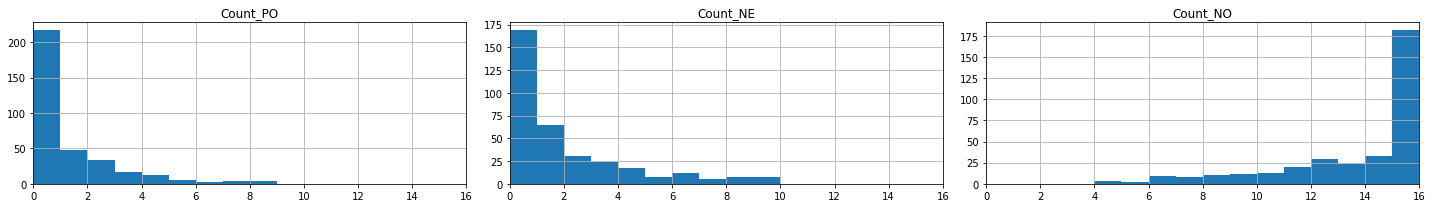

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(20,3))

n=1
binwidth = 1
for idx, col in enumerate(['Count_PO', 'Count_NE', 'Count_NO']):
    bins = np.arange(math.floor(min(mi[col]) * n) / n, 
                     math.ceil(max(mi[col]) * n) / n + binwidth, 
                     binwidth
                    )
    mi.hist(col, ax=ax[idx], bins=bins)
    ax[idx].set_xlim(0, 16)

plt.tight_layout()
plt.show()

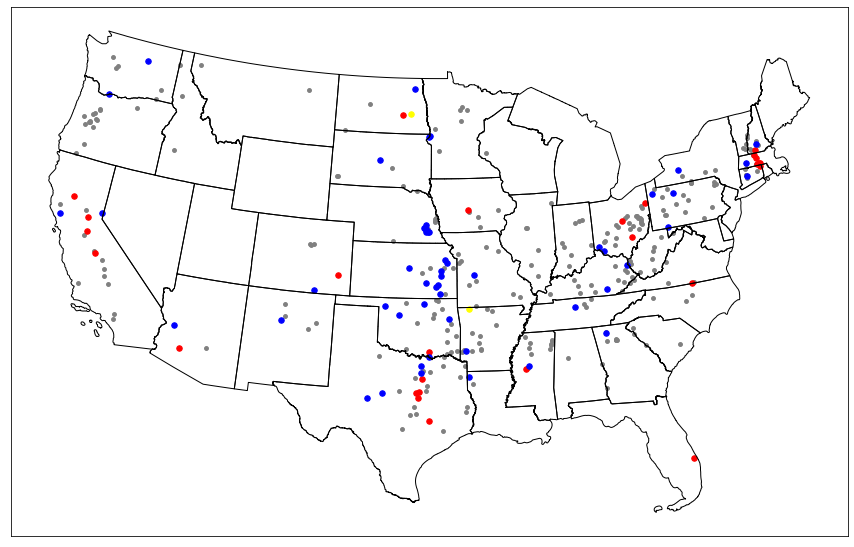

In [48]:
fig, ax = plt.subplots(figsize=(15,15))
state.boundary.plot(ax=ax, color='black', linewidth=1)

mi.loc[(mi['Count_PO'] < 4) & (mi['Count_NE'] < 4)].plot(color='grey', markersize=15, ax=ax)
mi.loc[(mi['Count_PO'] >= 4) & (mi['Count_NE'] < 4)].plot(color='red', markersize=30, ax=ax)
mi.loc[(mi['Count_NE'] >= 4) & (mi['Count_PO'] < 4)].plot(color='blue', markersize=30, ax=ax)
mi.loc[(mi['Count_PO'] >= 4) & (mi['Count_NE'] >= 4)].plot(color='yellow', markersize=30, ax=ax)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

## Locations and histograms of dams that shows more than 6 positive Moran's I

In [49]:
import mapclassify

print(mapclassify.NaturalBreaks(mi['Count_PO']))
print(mapclassify.NaturalBreaks(mi['Count_NE']))
print(mapclassify.NaturalBreaks(mi['Count_NO']))

NaturalBreaks       

  Interval     Count
--------------------
[0.00, 0.00] |   217
(0.00, 1.00] |    48
(1.00, 3.00] |    51
(3.00, 5.00] |    18
(5.00, 9.00] |    11
NaturalBreaks         

   Interval      Count
----------------------
[ 0.00,  0.00] |   169
( 0.00,  2.00] |    96
( 2.00,  4.00] |    41
( 4.00,  7.00] |    24
( 7.00, 10.00] |    15
NaturalBreaks         

   Interval      Count
----------------------
[ 4.00,  7.00] |    22
( 7.00, 10.00] |    35
(10.00, 12.00] |    49
(12.00, 14.00] |    57
(14.00, 16.00] |   182


/Users/jparkgeo/opt/anaconda3/envs/sa/lib/python3.8/site-packages/geopandas/plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


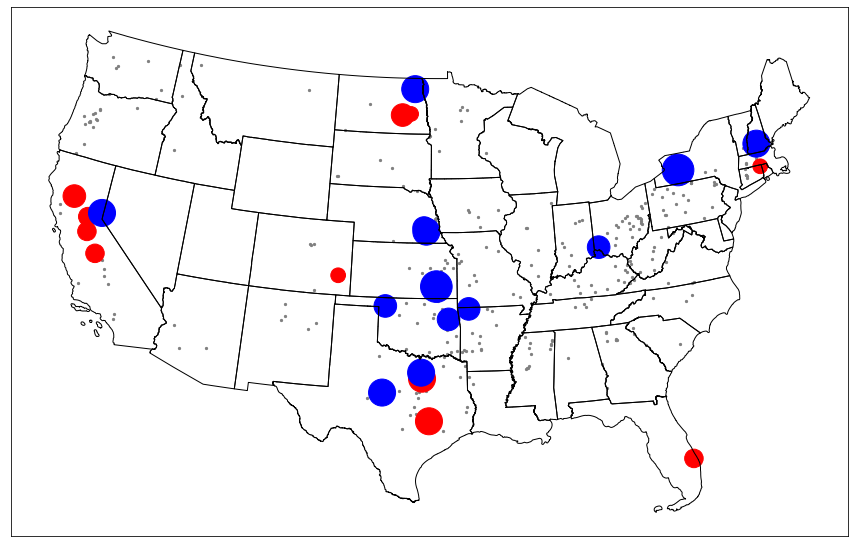

In [55]:
fig, ax = plt.subplots(figsize=(15,15))

state.boundary.plot(ax=ax, color='black', linewidth=1)

mi.plot(markersize=5, color='grey', ax=ax)

mi_po = mi.loc[mi['Count_PO'] >= 6]
mi_po.plot(markersize=mi_po['Count_PO'] ** 3, color='red', ax=ax)

mi_ne = mi.loc[mi['Count_NE'] >= 8]
mi_ne.plot(markersize=mi_ne['Count_NE'] ** 3, color='blue', ax=ax)

mi_mix = mi.loc[(mi['Count_NE'] >= 7) & (mi['Count_PO'] >= 6)]
mi_mix.plot(markersize=150, color='yellow', ax=ax)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

15 dams in the category Count_NE


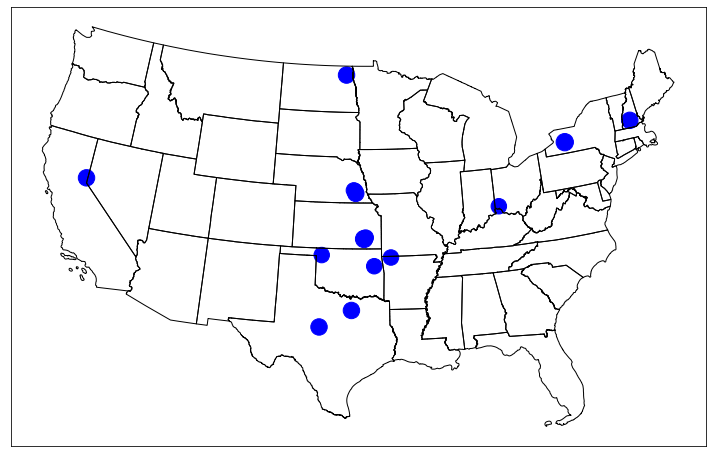

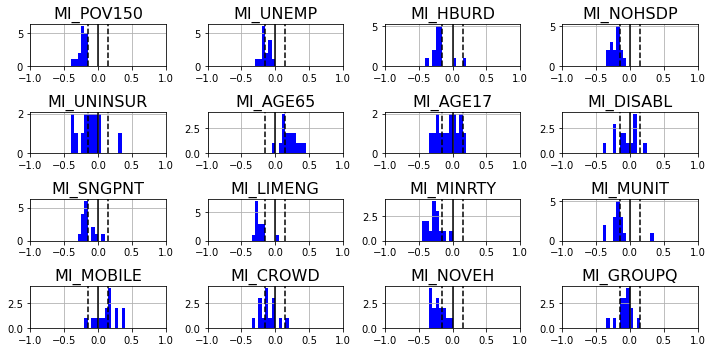

11 dams in the category Count_PO


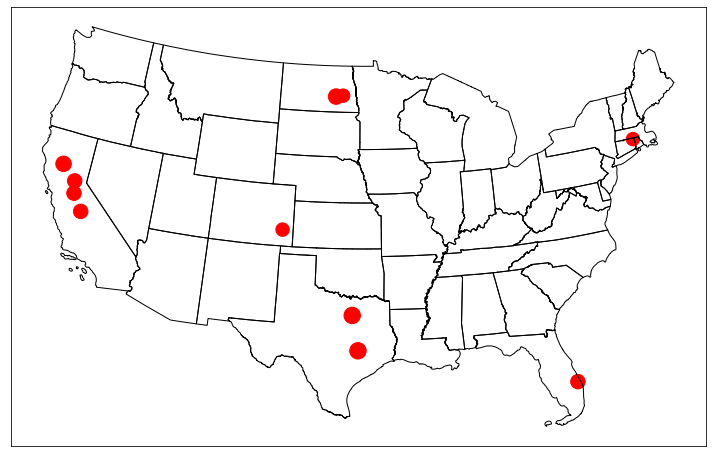

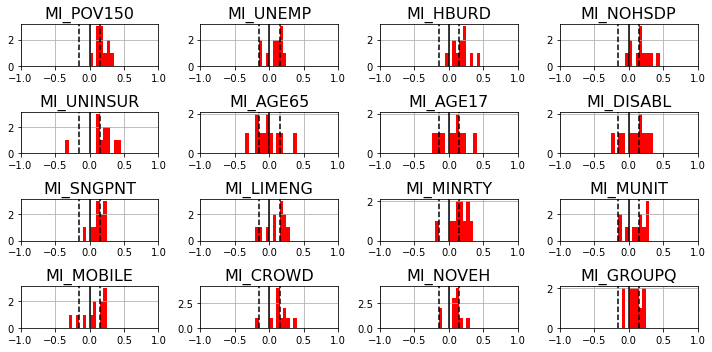

In [57]:
def plot_dams_per_characteristic(mi_gdf, col, plot_cols, state_gdf):
    if col == 'Count_NE':
        plot_color = 'blue'
        sel_num = 8
    elif col == 'Count_PO':
        plot_color = 'red'
        sel_num = 6
    else:
        plot_color = 'grey'
    temp_mi_gdf = mi_gdf.loc[mi_gdf[col] >= sel_num]
    print(f"{temp_mi_gdf.shape[0]} dams in the category {col}")


    fig, ax = plt.subplots(figsize=(10, 10))

    state_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    

    
    temp_mi_gdf.plot(markersize=temp_mi_gdf[col] * 30, color=plot_color, ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()
    
    
    fig, axes = plt.subplots(4, 4, figsize=(10,5))
    ax = axes.reshape(-1)

    binwidth = 0.05
    n = 10
    for idx, plot_col in enumerate(plot_cols):
        bins = np.arange(math.floor(min(temp_mi_gdf[plot_col]) * n) / n, math.ceil(max(temp_mi_gdf[plot_col]) * n) / n + binwidth, binwidth)
    
        temp_mi_gdf[plot_col].hist(ax=ax[idx], bins=bins, color=plot_color)
        ylim = ax[idx].get_ylim()[1]
        ax[idx].vlines(0, 0, ylim, color='black')
        ax[idx].vlines(-0.15, 0, ylim, color='black', linestyle='dashed')
        ax[idx].vlines(0.15, 0, ylim, color='black', linestyle='dashed')
        ax[idx].set_title(label=f"{plot_col}", fontsize=16)
        ax[idx].set_xlim(-1, 1)
        ax[idx].set_ylim(0, ylim)

    plt.tight_layout()
    plt.show()
    
    
    return temp_mi_gdf


negative_dams = plot_dams_per_characteristic(mi, 'Count_NE', plot_cols_mi, state)
positive_dams = plot_dams_per_characteristic(mi, 'Count_PO', plot_cols_mi, state)

2


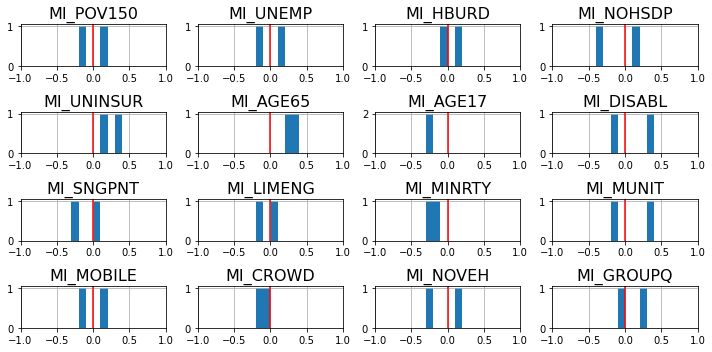

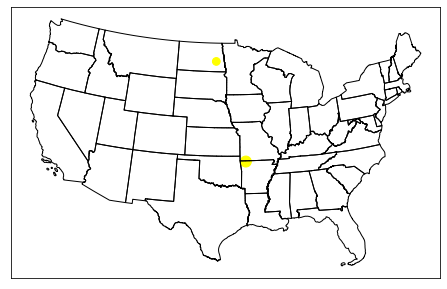

In [58]:
temp_mi = mi.loc[(mi['Count_NE'] >= 4) & (mi['Count_PO'] >= 4)]
print(temp_mi.shape[0])

fig, axes = plt.subplots(4, 4, figsize=(10,5))
ax = axes.reshape(-1)

binwidth = 0.1
n = 10
for idx, col in enumerate(plot_cols_mi):
    bins = np.arange(math.floor(min(temp_mi[col]) * n) / n, math.ceil(max(temp_mi[col]) * n) / n + binwidth, binwidth)
    temp_mi[col].hist(ax=ax[idx], bins=bins)
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='red')

    ax[idx].set_title(label=f"{col}", fontsize=16)
    ax[idx].set_xlim(-1, 1)
    ax[idx].set_ylim(0, ylim)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

state.boundary.plot(ax=ax, color='black', linewidth=1)
temp_mi.plot(markersize=temp_mi['Count_NE'] * 15, color='yellow', ax=ax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

262


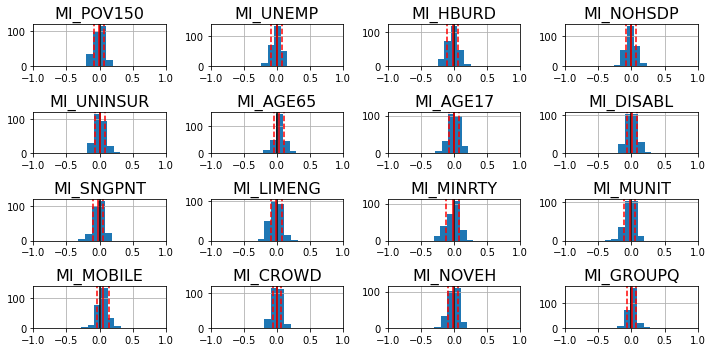

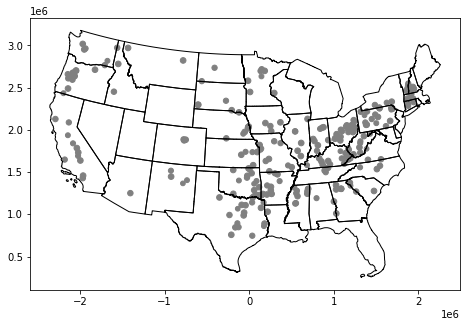

In [59]:
temp_mi = mi.loc[(mi['Count_PO'] < 4) & (mi['Count_NE'] < 4)]
print(temp_mi.shape[0])

fig, axes = plt.subplots(4, 4, figsize=(10,5))
ax = axes.reshape(-1)

binwidth = 0.1
for idx, col in enumerate(plot_cols_mi):
    temp_mi[col].hist(ax=ax[idx], bins=np.arange(min(temp_mi[col]), max(temp_mi[col]) + binwidth, binwidth))
    ylim = ax[idx].get_ylim()[1]
    ax[idx].vlines(0, 0, ylim, color='black')
    ax[idx].vlines(temp_mi[col].mean(), 0, ylim, color='red')
    ax[idx].vlines(temp_mi[col].mean() - temp_mi[col].std(), 0, ylim, color='red', linestyle='dashed')
    ax[idx].vlines(temp_mi[col].mean() + temp_mi[col].std(), 0, ylim, color='red', linestyle='dashed')

    ax[idx].set_title(label=f"{col}", fontsize=16)
    ax[idx].set_xlim(-1, 1)
    ax[idx].set_ylim(0, ylim)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

state.boundary.plot(ax=ax, color='black', linewidth=1)
temp_mi.plot(markersize=temp_mi['Count_NO'] * 2, color='grey', ax=ax)
plt.show()

In [60]:
mi.sort_values('Count_NE', ascending=False).head()

ID        LAT         LON              NAME  LIBRARY_ID  \
2    NY00468  42.733294  -77.907232  MOUNT MORRIS DAM         316   
195  KS00003  37.650833  -96.062907    FALL RIVER DAM        4746   
293  TX00005  32.969859  -97.056211     GRAPEVINE DAM        1466   
105  ND00310  48.404682  -97.791287         HOMME DAM        1008   
183  CA10108  39.327234 -120.114789  MARTIS CREEK DAM        6669   

    LIBRARY_TYPE  MH_F   IH_F  TAS_F  SS_F  ...  Code_LIMENG  Code_MINRTY  \
2      dam_study  True  False   True  True  ...         NE_C         NE_C   
195    dam_study  True   True   True  True  ...         NE_C         NO_C   
293    dam_study  True  False   True  True  ...         NE_C         NE_C   
105    dam_study  True  False   True  True  ...         NE_C         NE_C   
183    dam_study  True   True   True  True  ...         NE_C         NE_C   

     Code_MUNIT  Code_MOBILE  Code_CROWD  Code_NOVEH  Code_GROUPQ  Count_NE  \
2          NE_C         PO_C        NO_C        NE_C         NO_C      10.0   
195        NE_C         PO_C        NO_C        NE_C         NE_C      10.0   
293        NE_C         PO_C        NO_C        NE_C         NO_C       9.0   
105        NE_C         NO_C        NO_C        NE_C         NE_C       9.0   
183        NE_C         NO_C        NE_C        NO_C         NO_C       9.0   

     Count_PO  Count_NO  
2         2.0       4.0  
195       1.0       5.0  
293       1.0       6.0  
105       1.0       6.0  
183       1.0       6.0  

[5 rows x 88 columns]

In [61]:
mi.sort_values('Count_PO', ascending=False).head()

ID        LAT         LON             NAME  LIBRARY_ID LIBRARY_TYPE  \
290  TX00013  30.320402  -96.524091   SOMERVILLE DAM        4386    dam_study   
262  TX08007  32.644010  -96.990959     JOE POOL DAM         742    dam_study   
8    CA10102  39.816287 -122.336676  BLACK BUTTE DAM         776    dam_study   
171  ND00146  46.961748  -98.752500     PIPESTEM DAM         769    dam_study   
344  CA10244  37.110662 -119.884580       HIDDEN DAM        5887    dam_study   

     MH_F   IH_F  TAS_F  SS_F  ...  Code_LIMENG  Code_MINRTY  Code_MUNIT  \
290  True   True   True  True  ...         NO_C         NO_C        NO_C   
262  True  False   True  True  ...         PO_C         PO_C        NO_C   
8    True  False   True  True  ...         PO_C         NO_C        PO_C   
171  True  False   True  True  ...         NO_C         PO_C        PO_C   
344  True   True   True  True  ...         NO_C         PO_C        PO_C   

     Code_MOBILE  Code_CROWD  Code_NOVEH  Code_GROUPQ  Count_NE  Count_PO  \
290         PO_C        PO_C        NO_C         NO_C       0.0       9.0   
262         PO_C        PO_C        NO_C         NO_C       0.0       9.0   
8           PO_C        NO_C        NO_C         NO_C       2.0       8.0   
171         NO_C        NO_C        PO_C         NO_C       0.0       8.0   
344         NE_C        PO_C        NO_C         NO_C       2.0       7.0   

     Count_NO  
290       7.0  
262       7.0  
8         6.0  
171       8.0  
344       7.0  

[5 rows x 88 columns]

## Correlation between the Moran's I which indicates the correlation between Inundated Area and SVI related variables 

<AxesSubplot:>

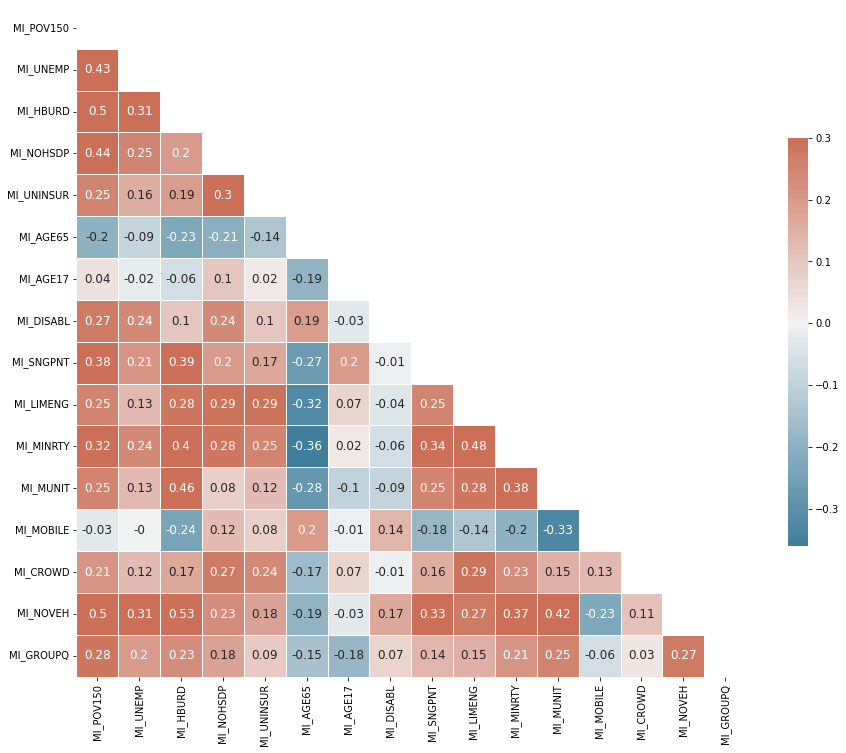

In [76]:
corr = mi[plot_cols_mi].corr('kendall')
corr = corr.round(decimals=2)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, annot_kws={"fontsize":12})

In [63]:
import matplotlib.colors as colors

In [64]:
def shiftedColorMap(cmap, start=-0.37, midpoint=0.5, stop=0.49, name='shiftedcmap_'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

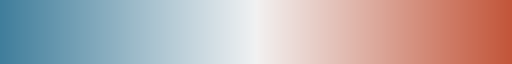

In [65]:
cmap

In [66]:
corr.min().min()

-0.36

In [67]:
max_val = 0
for col in corr.columns:
    temp_max = corr[col].nlargest(2)[1]
    if temp_max > max_val:
        max_val = temp_max
max_val

0.53

In [75]:
cmap_ = sns.diverging_palette(220, 20, as_cmap=True)

cmap_shifted = shiftedColorMap(cmap_, start=0, midpoint=1, stop=1.5)
cmap_shifted

NameError: name 'shiftedColorMap' is not defined

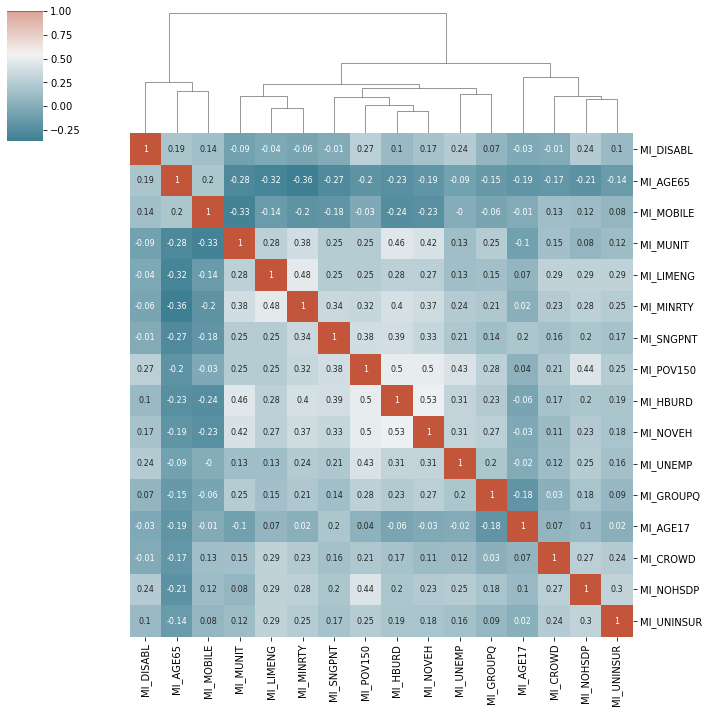

In [69]:
corr = mi[plot_cols_mi].corr('kendall')
corr = corr.round(decimals=2)
# corr = corr +1

g = sns.clustermap(corr, method='ward', cmap=cmap_shifted, annot=True, annot_kws={"fontsize":8})

values = g.ax_heatmap.collections[0].get_array().reshape(corr.shape)
new_values = np.ma.array(values)
g.ax_heatmap.collections[0].set_array(new_values)
g.ax_row_dendrogram.set_visible(False)
plt.show()

## Dam locations per variable and per Positive / Negative Moran's I 

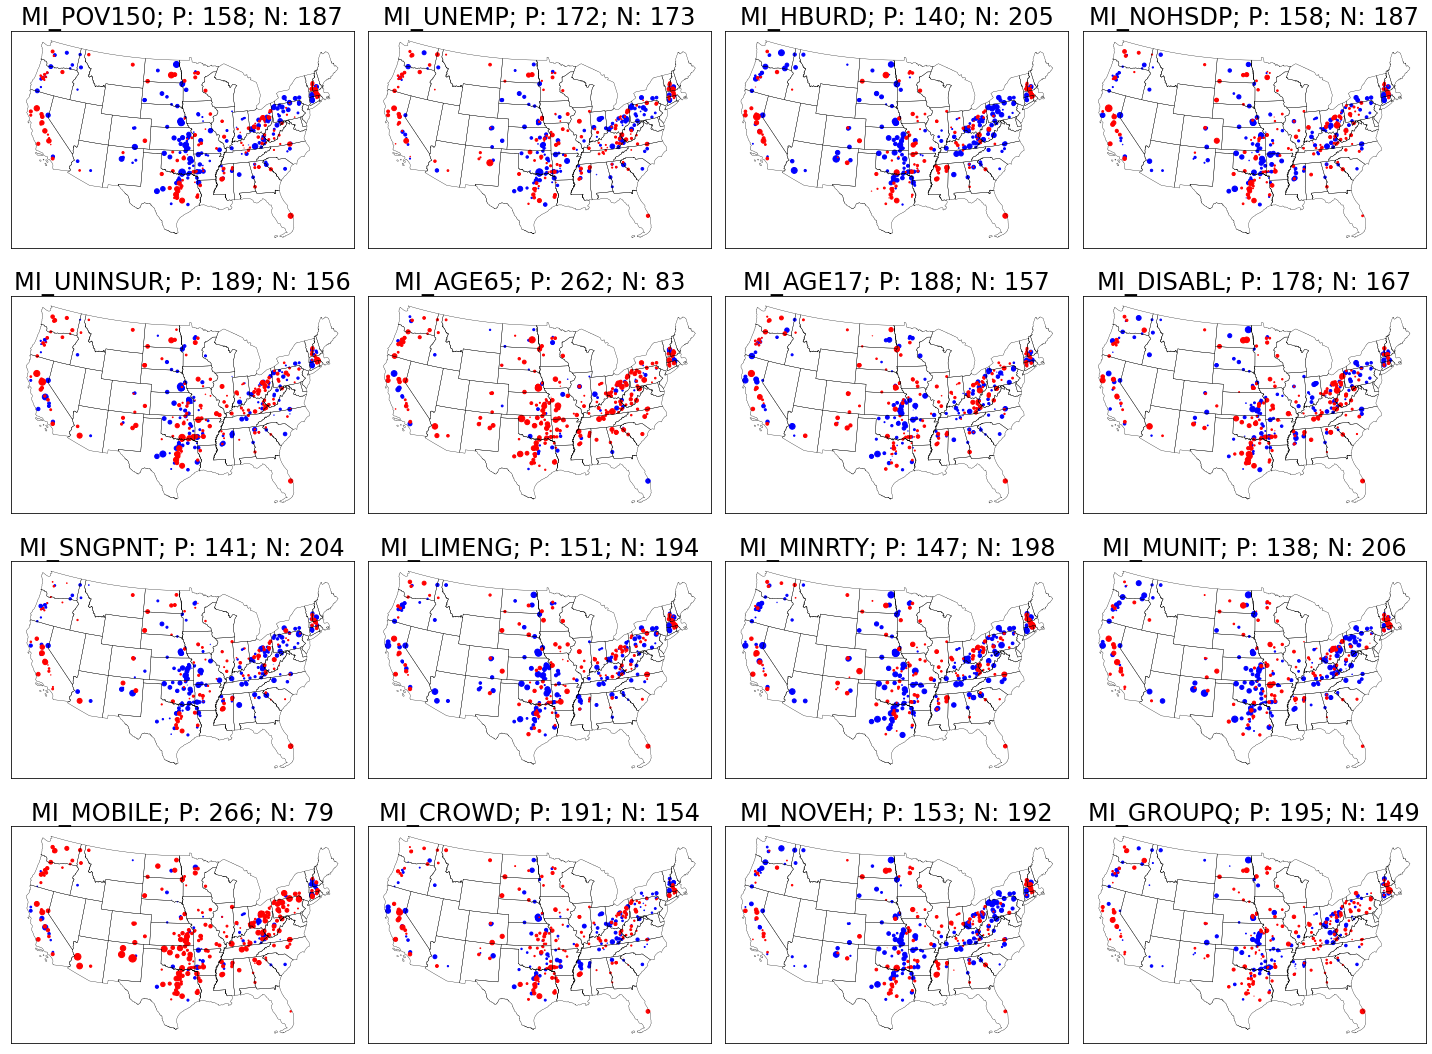

In [70]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))

ax = axes.reshape(-1)
  
for idx, col in enumerate(plot_cols_mi):
    state.boundary.plot(ax=ax[idx], color='black', linewidth=0.3)
    
    negative_mi = mi.loc[mi[col] < 0]
    negative_mi.plot(markersize=negative_mi[col].abs()*100, color='blue', ax=ax[idx])
    positive_mi = mi.loc[mi[col] > 0]
    positive_mi.plot(markersize=positive_mi[col].abs()*100, color='red', ax=ax[idx])
    
    ax[idx].set_title(label=f"{col}; P: {positive_mi.shape[0]}; N: {negative_mi.shape[0]}", fontsize=24)
    ax[idx].get_xaxis().set_visible(False)
    ax[idx].get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()
